# Univariate time series forecasting:

In this code the results of timeseries forecasting for 12 different datasets have been collected. One-step ahead recursive forecasting have been used on each one of them as a univariate time series forecasting problem.
The collected data has been plotted based on metrics used. RMSE (root mean squared error) and MSLE (mean logarithmic squared error) have been used as our metrics for comparison.

List of approaches:
- classical methods such as SARIMA or ARIMA
- Multilayar Perceptron (MLP)
- Stacked Unidirectional and Bidirectional Long Short Term Memory networks (LSTM)
- Recurrent Neural Networks (RNN)
- Gated Recurrent Unit (GRU)
- Convolution based networks (CNN-LSTM)
- Dilated Causal Convolutions (DC-CNN)
- SeriesNet
- WaveNet

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import keras
import tensorflow
import statsmodels.tsa as sm 
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMAResults, ARIMA
from statsmodels.graphics import tsaplots
from statsmodels.graphics.gofplots import qqplot
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
import seaborn as sns
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, LSTM, Activation, Bidirectional, Flatten, TimeDistributed, SimpleRNN, Dropout, GRU, Input, Add, Multiply
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers.normalization import BatchNormalization
from keras import optimizers, initializers
from keras.regularizers import l2
from keras.initializers import TruncatedNormal, Constant, RandomNormal
from keras.layers.advanced_activations import LeakyReLU, ELU
import pickle
%matplotlib inline

In [2]:
np.random.seed(2019) # for initializing models with same weights every time.
from tensorflow import set_random_seed
set_random_seed(2019)
validation_split = 0.25

In [3]:
#metrics:
#root mean squared error:
def RMSE(y_true, y_pred): 
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return rmse

#mean absolute percentage error
def MAPE(y_true, y_pred): 
    mape = np.mean(np.abs((np.array(y_true) - np.array(y_pred)) / np.array(y_true))) * 100
    return mape

#symmetric mean absolute error
def SMAPE(y_true, y_pred):
    smape = 100/len(y_true) * np.sum(2 * np.abs(np.array(y_pred) - np.array(y_true)) / (np.abs(np.array(y_true)) + np.abs(np.array(y_pred))))
    return smape

#mean squared logarithmic error:
def MSLE(y_true, y_pred): 
    rmse = mean_squared_log_error(y_true, y_pred)
    return rmse

# Importing Dataset and Plotting:

Source of dataset: https://github.com/PacktPublishing/Practical-Time-Series-Analysis-V-/tree/master/Data%20Files

The goal is to perfrom univariate time series forecasting via one-step ahead recursive forecasting. Performance of classical methods and deep learning approaches will be compared to each other.

ADF test results: (-0.3556681172874026, 0.9172416481644101, 14, 146, {'1%': -3.4759527332353084, '5%': -2.881548071241103, '10%': -2.577438765246763}, -832.1029272203816)
High p-value of ADF test (0.9172416481644101) shows that we fail to reject null hypothesis. 
 Hence, the dataset is non-stationary.


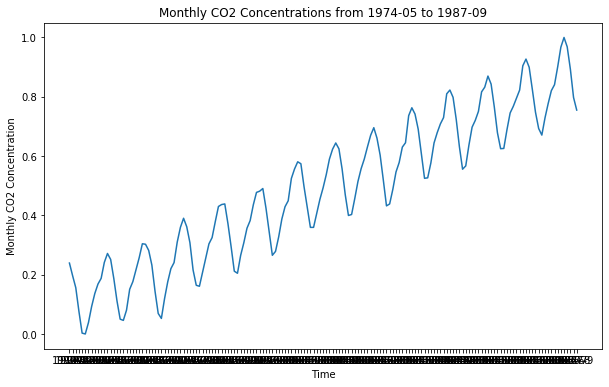

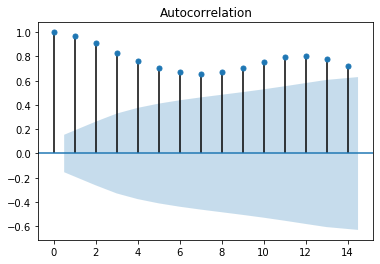

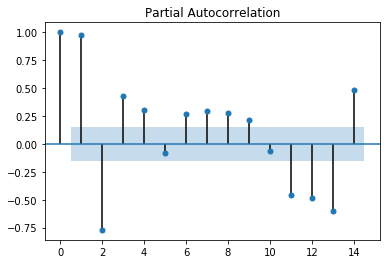

In [13]:
CO2 = pd.read_excel('/home/ahmada59/Datasets/UCRArchive_2018/Monthly_CO2_Concentrations.xlsx',
                    converters={'Year': np.int32, 'Month': np.int32}).dropna()
CO2.sort_values(['Year', 'Month'], inplace=True)
CO2.index = [i for i in range(161)]
Date = [(str(CO2.Year[i]) + '-' + str(CO2.Month[i])) for i in range(len(CO2))]
scaler = MinMaxScaler(feature_range=(0, 1))
df = pd.DataFrame({"Concentrations":scaler.fit_transform(np.array(CO2['CO2']).reshape(161,1)).reshape(161,)},
                  index = Date)
plt.figure(figsize=(10,6))
plt.plot(df)
plt.xlabel('Time')
plt.ylabel('Monthly CO2 Concentration')
plt.title('Monthly CO2 Concentrations from 1974-05 to 1987-09')
plt.savefig('fig8.png', dpi=800, quality=95)
tsaplots.plot_acf(df, ax=None, lags=np.arange(15), use_vlines=True)
tsaplots.plot_pacf(df, ax=None, lags=np.arange(15), use_vlines=True)
print("ADF test results:", sm.stattools.adfuller(df.iloc[:,0], autolag='AIC'))
print('High p-value of ADF test ({}) shows that we fail to reject null hypothesis. \n Hence, the dataset is non-stationary.'.format(sm.stattools.adfuller(df.iloc[:,0], autolag='AIC')[1]))

ACF and PACF plots display significant correlation between lags, and hence data is non-stationary. One approach is to take out trend by rolling average and make it stationar for classical analysis.

Manually decomposing trend and seasonality:
 - taking out trend by moving average smoothing method

/home/avesta/anaconda3/envs/py35/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


ADF test results: (-4.589452105697076, 6.44517290244235e-06, 1, 147, {'1%': -2.5811173705400527, '5%': -1.942973103736381, '10%': -1.6151308082642561}, -830.6902580487357)
low p-value of ADF test (0.0001443345540844188) shows that we will reject null hypothesis. 
 Hence, the residual is close to stationary.
P-value of ADF test on the noise (with no constant no trend) shows that data is stationary.
 Hence, we can say that data is trend stationary.


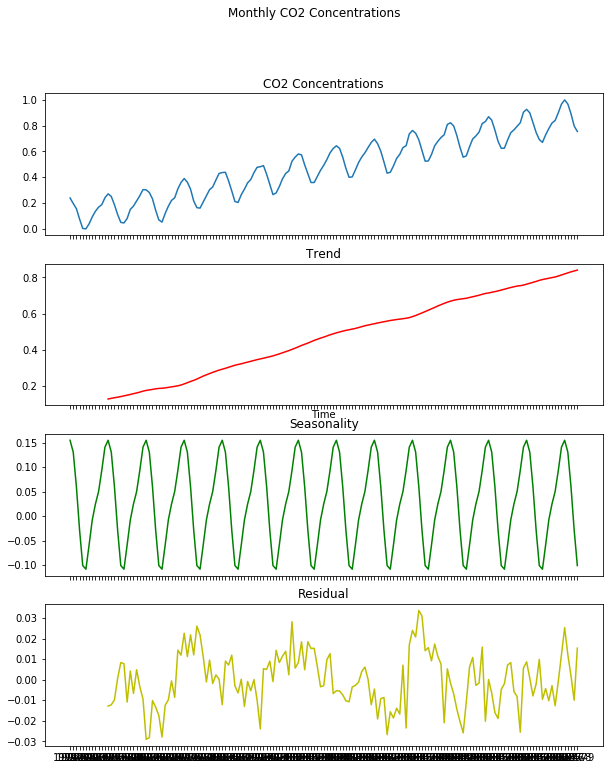

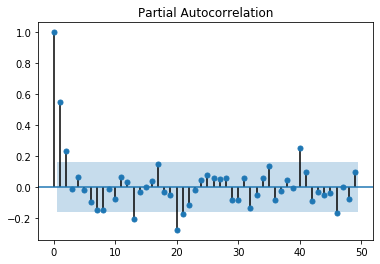

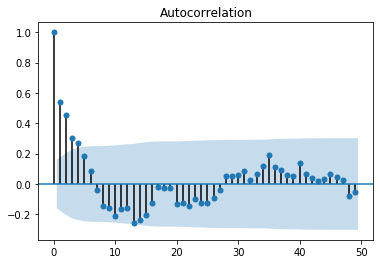

In [14]:
trendcomp = (df.rolling(12).mean()).rolling(2).mean()
res = (df - trendcomp).dropna()
#taking month-wise averages for seasonality
month = res.index.map(lambda d: d[5:7])
res1 = res.groupby(by = month).aggregate(['mean'])
res1[res1.index == res.index[0].split(sep='-')[1]].values.reshape(1,).tolist()
seasonalcomp = [0 for i in range(len(trendcomp))]
for i in range(len(trendcomp)):
    seasonalcomp[i] = res1[res1.index == trendcomp.index[i].split(sep='-')[1]].values.reshape(1,).tolist()
noise = df.iloc[:,0] - trendcomp.iloc[:,0]- np.array(seasonalcomp).reshape(161,)
df['trendcomp'] = trendcomp.values
df['seasonalcomp'] = np.array(seasonalcomp).reshape((161,1))
df['noise'] = noise.values
fig = plt.figure(1, figsize=[10,12])
fig.suptitle('Monthly CO2 Concentrations')
fig1, fig2, fig3, fig4 = fig.subplots(nrows=4, ncols=1, sharex=True, sharey=False)
fig1.set_title('CO2 Concentrations')
fig2.set_title('Trend')
fig3.set_title('Seasonality')
fig4.set_title('Residual')
fig2.set_xlabel('Time')
fig1.plot(df.loc[:,'Concentrations'])
fig2.plot(df.loc[:,'trendcomp'], 'r')
fig3.plot(df.loc[:,'seasonalcomp'], 'g')
fig4.plot(df.loc[:,'noise'], 'y')
fig.show()
# taking auto correlations for stationary residual.
tsaplots.plot_pacf(noise.dropna(), ax=None, lags=np.arange(50), use_vlines=True)
tsaplots.plot_acf(noise.dropna(), ax=None, lags=np.arange(50), use_vlines=True)
#ADF test on residual
print("ADF test results:", sm.stattools.adfuller(df.loc[:,'noise'].dropna(), regression='nc', autolag='AIC'))
print('low p-value of ADF test ({}) shows that we will reject null hypothesis. \n Hence, the residual is close to stationary.'.format(sm.stattools.adfuller(df.loc[:,'noise'].dropna(), autolag='AIC')[1]))
print('P-value of ADF test on the noise (with no constant no trend) shows that data is stationary.\n Hence, we can say that data is trend stationary.')

Seasonal decompose of trend and seasonality:

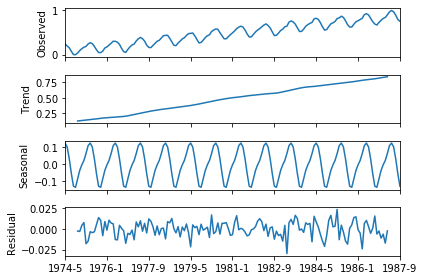

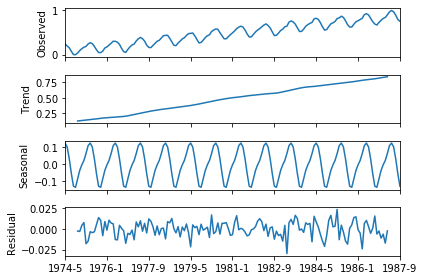

In [7]:
decomp_df = seasonal_decompose(df.loc[:,'Concentrations'], model='additive', freq=12)
decomp_df.plot()

Manually decompose of seasonality and trend: 
    - differencing method to see if time series is difference stationary!

ADF test results: (-3.773497529280954, 0.0001759756762867921, 12, 147, {'1%': -2.5811173705400527, '5%': -1.942973103736381, '10%': -1.6151308082642561}, -841.480694705032)
low p-value of ADF test (0.0001759756762867921) shows that we will reject null hypothesis. 
 Hence, the residual is close to stationary.
Data is not getting stationary by multiple differencings. So data is trend stationary.


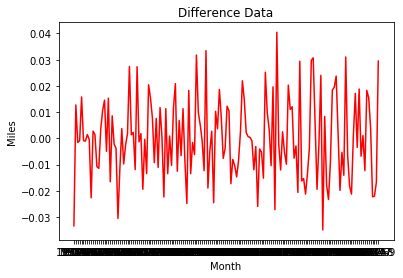

In [8]:
diff1 = ((df.loc[:,'Concentrations'].diff(1)))
nn = diff1.dropna() - df.seasonalcomp[1:]
plt.plot(nn,'r')
plt.title('Difference Data')
plt.xlabel('Month')
plt.ylabel('Miles')
#ADF test on difference data
print("ADF test results:", sm.stattools.adfuller(nn, regression='nc', autolag='AIC'))
print('low p-value of ADF test ({}) shows that we will reject null hypothesis. \n Hence, the residual is close to stationary.'.format(sm.stattools.adfuller(nn, regression='nc', autolag='AIC')[1]))
print('Data is not getting stationary by multiple differencings. So data is trend stationary.')

# Train Test Split:

In [5]:
trainfrac = 0.75
df_train, df_test = train_test_split(df, train_size=trainfrac, shuffle=False, stratify=None)

# ARIMA

Finding best arima model and fitting:

In [8]:
results = pd.DataFrame({"p": [], "d": [], "q":[], "aic": []})
results = results[['p','d','q','aic']]
for d in range(0,3):
    for p in range(0,3):
        for q in range(0,3):
            try:
                df_arima = sm.arima_model.ARIMA(df_train.loc[:,'Concentrations'].tolist(), order=(p,d,q))
                #the value of start_params defines that the model will converge or not.
                #values equal or greater than 1 won't converge at all. Values less than 1 will most probably 
                #converge. If not, try decreasing the parameters to lower values.
                df_arima_fit = df_arima.fit(start_params=0.01*np.ones(p+q+1))
                dd = pd.DataFrame({'p':[p], 'd':[d], 'q':[q], 'aic':[df_arima_fit.aic]})
                dd = dd[['p','d','q','aic']]
                results = results.append(dd)
            except ValueError:
                pass
print("p", "d", "q", "    AIC\n", sep='        ')
for i in range(results.shape[0]):
    print("{0:1d}, {1:7d}, {2:7d}, {3:17f}\n".format(results.values[i][0].astype('int64'), results.values[i][1].astype('int64'), results.values[i][2].astype('int64'), results.values[i][3]))
opt_arima = (results[results.loc[:,'aic'] == results['aic'].min()].values[0]).astype('int64')
print(" - The minimum AIC value can be obtained by p={}, d={}, q={} paramteres.".format(opt_arima[0],opt_arima[1], opt_arima[2]))
print(" - ARIMA({},{},{}) will be chosen as the best model.".format(opt_arima[0],opt_arima[1], opt_arima[2]))

/home/ahmada59/anaconda3/envs/py35/lib/python3.5/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/home/ahmada59/anaconda3/envs/py35/lib/python3.5/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/home/ahmada59/anaconda3/envs/py35/lib/python3.5/site-packages/scipy/signal/signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `

p        d        q            AIC

0,       0,       0,        -46.381736

0,       0,       1,       -191.283763

0,       0,       2,       -306.908501

1,       0,       0,       -366.469870

1,       0,       1,       -433.941851

1,       0,       2,       -471.610781

2,       0,       0,       -369.992517

2,       0,       1,       -467.184459

2,       0,       2,       -481.929997

0,       1,       0,       -368.315654

0,       1,       1,       -434.910160

0,       1,       2,       -471.207854

1,       1,       0,       -450.159802

1,       1,       1,       -461.896131

1,       1,       2,       -477.735921

2,       1,       0,       -476.750772

2,       1,       1,       -522.301607

2,       1,       2,       -483.225250

0,       2,       0,       -431.396533

0,       2,       1,       -436.801268

0,       2,       2,       -441.609574

1,       2,       0,       -437.673059

1,       2,       1,       -435.761565

1,       2,       2,       -440.898121

2,  

In [9]:
df_arima = sm.arima_model.ARIMA(df_train['Concentrations'].tolist(), order=(opt_arima[0],opt_arima[1],opt_arima[2]))
df_arima_fit = df_arima.fit(start_params=0.01*np.ones(opt_arima[0]+opt_arima[2]+1))
df_arima_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                  119
Model:                 ARIMA(2, 1, 1)   Log Likelihood                 266.151
Method:                       css-mle   S.D. of innovations              0.025
Date:                Tue, 26 Nov 2019   AIC                           -522.302
Time:                        13:48:47   BIC                           -508.406
Sample:                             1   HQIC                          -516.659
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0051      0.000     22.719      0.000       0.005       0.006
ar.L1.D.y      1.5649      0.046     33.881      0.000       1.474       1.655
ar.L2.D.y     -0.8643      0.046    -18.908      0.000      -0.954      -0.775
ma.L1.D.y     -1.0000      0.023    -43.250      0.000      -1.045      -0.955
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.9053           -0.5809j            1.0756           -0.0908
AR.2            0.9053           +0.5809j            1.0756            0.0908
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

Evaluating arima model:

/home/ahmada59/anaconda3/envs/py35/lib/python3.5/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/home/ahmada59/anaconda3/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/ahmada59/anaconda3/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-

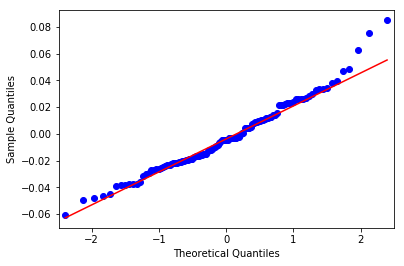

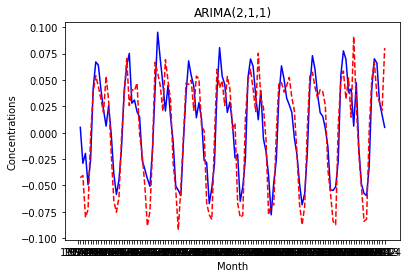

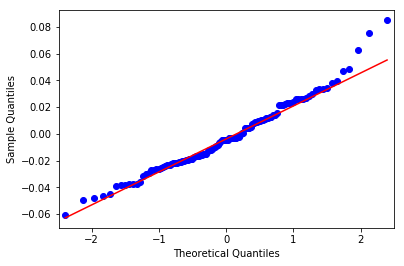

In [11]:
df_train.loc[opt_arima[1]:,'ARIMA'] = np.append([], df_arima_fit.fittedvalues)
df_train.loc[opt_arima[1]:,'diff'] = np.append([], df_arima_fit.fittedvalues + df_arima_fit.resid)
plt.plot(df_train.loc[:,'ARIMA'], 'b-', df_train.loc[:,'diff'], 'r--')
plt.xlabel('Month')
plt.ylabel('Concentrations')
plt.title('ARIMA({},{},{})'.format(opt_arima[0],opt_arima[1], opt_arima[2]))
# plotting qq plot for normality check of residuals to iid noise
qqplot(data=df_arima_fit.resid, loc=0.0, scale=1.0, line='q')

As we can see the QQ-plot on the residuals of the arima model is close to normal. Hence we can deduce that the order of parameters are suitable to take the behaviour of the time series.

Now Let's fit a seasonal arima model to the time series.

# Seasonal AIRMA:

ADF result equals to 3.3660270880418845e-07, which confirms that lag 12 could capture seasonality


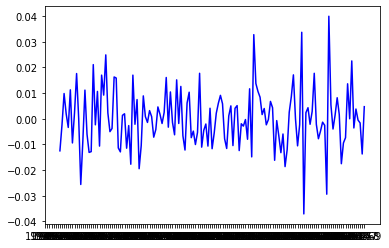

In [20]:
# finding the value of seasonality lag
x = (df.Concentrations - df.trendcomp).diff(12)
x.dropna()
plt.plot(x,'b')
print('ADF result equals to {}, which confirms that lag 12 could capture seasonality'.format(sm.stattools.adfuller(x.dropna(), regression='nc', autolag='AIC')[1]))
seasonality = 12

In [21]:
results = pd.DataFrame({"p": [], "d": [], "q":[], "P":[], "D":[], "Q":[], "aic": []})
results = results[['p','d','q','P','D','Q','aic']]
for p in range(0,3):
    for d in range(1,3):
        for q in range(0,3):
            for P in range(0,3):
                for D in range(1,3):
                    for Q in range(0,3):
                        try:
                            df_SARIMAX = SARIMAX(df_train['Concentrations'].tolist(), trend='n', 
                                                 order=(p,d,q),seasonal_order=(P,D,Q,seasonality))
                            df_SARIMAX_fit = df_SARIMAX.fit(start_params = 0.01*np.ones(p+q+P+Q+1),maxiter=20000)
                            dd = pd.DataFrame({'p':[p], 'd':[d], 'q':[q], "P":[P], "D":[D], "Q":[Q],
                                               'aic':[df_SARIMAX_fit.aic]})
                            dd = dd[['p','d','q','P','D','Q','aic']]
                            results = results.append(dd)
                        except ValueError:
                            pass
print("p", "d", "q", "P", "D", "Q", "AIC\n", sep='        ')
for i in range(results.shape[0]):
    print("{0:1d}, {1:7d}, {2:7d}, {3:7d}, {4:7d}, {5:7d}, {6:17f}\n".format(results.values[i][0].astype('int64'),
                                                                             results.values[i][1].astype('int64'),
                                                                             results.values[i][2].astype('int64'),
                                                                             results.values[i][3].astype('int64'),
                                                                             results.values[i][4].astype('int64'),
                                                                             results.values[i][5].astype('int64'),
                                                                             results.values[i][6]))
opt_sarima = (results[results.loc[:,'aic'] == results['aic'].min()].values[0]).astype('int64')
print(" - The minimum AIC value can be obtained by p={}, d={}, q={}, P={}, D={}, Q={} paramteres."
      .format(opt_sarima[0],opt_sarima[1], opt_sarima[2], opt_sarima[3], opt_sarima[4], opt_sarima[5]))
print(" - ARIMA({},{},{})({},{},{}) will be chosen as the best model.".format(opt_sarima[0],opt_sarima[1],
                                                                              opt_sarima[2],opt_sarima[3],
                                                                              opt_sarima[4], opt_sarima[5]))

/home/avesta/anaconda3/envs/py35/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/avesta/anaconda3/envs/py35/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/avesta/anaconda3/envs/py35/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/avesta/anaconda3/envs/py35/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/avesta/anaconda3/envs/py35/lib/python3.6/site-packages/statsmodels/base/model.py:512: Converge

/home/avesta/anaconda3/envs/py35/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/avesta/anaconda3/envs/py35/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/avesta/anaconda3/envs/py35/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/avesta/anaconda3/envs/py35/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/avesta/anaconda3/envs/py35/lib/python3.6/site-packages/statsmodels/base/model.py:512: Converge

p        d        q        P        D        Q        AIC

0,       1,       0,       0,       1,       0,       -594.699274

0,       1,       0,       0,       1,       1,       -607.907349

0,       1,       0,       0,       1,       2,       -608.576318

0,       1,       0,       0,       2,       0,       -430.100304

0,       1,       0,       0,       2,       1,       -488.772084

0,       1,       0,       0,       2,       2,       -494.952276

0,       1,       0,       1,       1,       0,       -606.716359

0,       1,       0,       1,       1,       1,       -605.284584

0,       1,       0,       1,       1,       2,       -604.121809

0,       1,       0,       1,       2,       0,       -478.827385

0,       1,       0,       1,       2,       1,       -495.440679

0,       1,       0,       1,       2,       2,       -493.066278

0,       1,       0,       2,       1,       0,       -605.082210

0,       1,       0,       2,       1,       1,       -609.950222

0, 

In [22]:
df_SARIMAX = SARIMAX(df_train['Concentrations'].tolist(), trend='n', order=(opt_sarima[0],opt_sarima[1],opt_sarima[2]),seasonal_order=(opt_sarima[3],opt_sarima[4],opt_sarima[5],seasonality))
df_SARIMAX_fit = df_SARIMAX.fit(start_params = 0.01*np.ones(1+opt_sarima[0]+opt_sarima[2]+opt_sarima[3]+ opt_sarima[5]),
                                method='lbfgs', maxiter=20000)
df_SARIMAX_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  120
Model:             SARIMAX(0, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 319.235
Date:                            Sun, 01 Dec 2019   AIC                           -630.470
Time:                                    10:38:08   BIC                           -619.779
Sample:                                         0   HQIC                          -626.136
                                            - 120                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4433      0.085     -5.220      0.000      -0.610      -0.277
ar.S.L12       0.2670      0.147      1.814      0.070      -0.021       0.556
ma.S.L12      -0.9478      0.607     -1.563      0.118      -2.137       0.241
sigma2         0.0001    6.8e-05      1.887      0.059   -4.95e-06       0.000
===================================================================================
Ljung-Box (Q):                       34.90   Jarque-Bera (JB):                 1.88
Prob(Q):                              0.70   Prob(JB):                         0.39
Heteroskedasticity (H):               0.91   Skew:                             0.29
Prob(H) (two-sided):                  0.77   Kurtosis:                         3.29
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Saving/loading SARIMA results:

In [23]:
df_SARIMAX_fit.save('/home/ahmada59/py/CO2Concentrations_SARIMA.pkl')
#df_SARIMAX_fit = ARIMAResults.load('/home/ahmada59/py/CO2Concentrations_SARIMA.pkl')

As we can see the QQ-plot on the residuals of the SARIMA model is close to normal. Hence we can deduce that the order of parameters are suitable to take the behaviour of the time series.


We also plot ACF and PAC>F plots for the residual to make sure there is no correlation between lags of residuals and it is stationary (iid noise).

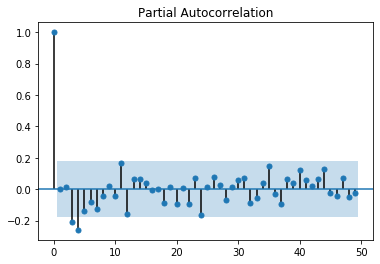

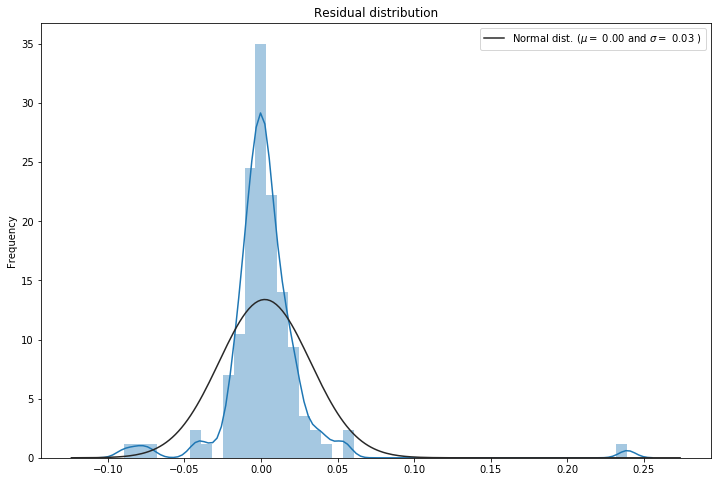

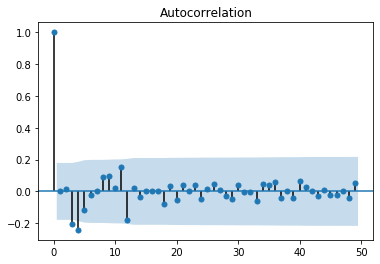

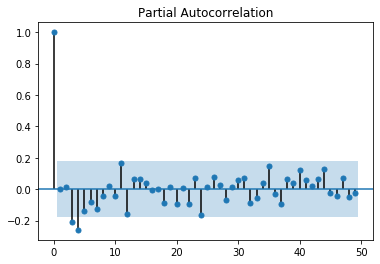

In [24]:
# Checking if the residuals are iid noise.
resid = df_SARIMAX_fit.resid
fig = plt.figure(figsize=(12,8))
sns.distplot(resid, fit=stats.norm)
(mu, sigma) = stats.norm.fit(resid)
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('Residual distribution')
tsaplots.plot_acf(resid, ax=None, lags=np.arange(50), use_vlines=True)
tsaplots.plot_pacf(resid, ax=None, lags=np.arange(50), use_vlines=True)

/home/avesta/anaconda3/envs/py35/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


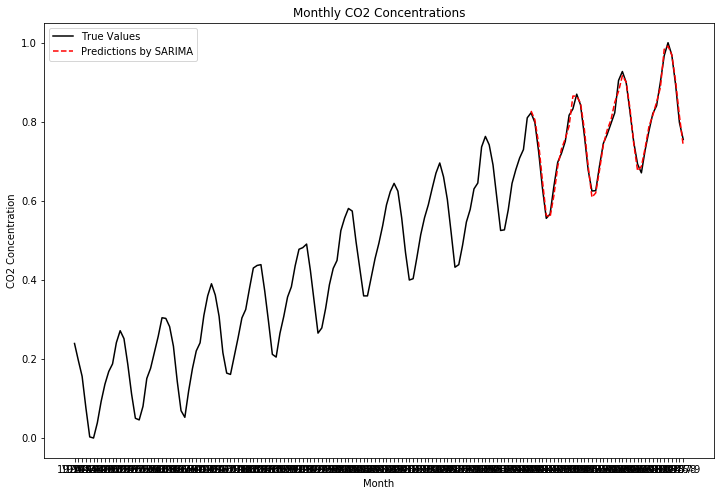

In [26]:
def sarima_forecast_recursive(history, config, n):
    model = SARIMAX(history,trend=config['trend'], order=config['order'],seasonal_order=config['seasonal_order'])
    fittedmodel = model.fit(start_params = np.ones(n)*0.01, method='lbfgs', maxiter=2000)
    forecast = fittedmodel.forecast(steps=1, alpha=0.05)
    return forecast

# config referes to sarima model that is the same for recursive forecasting.
config = {"order":[opt_sarima[0],opt_sarima[1],opt_sarima[2]], 
          "seasonal_order":[opt_sarima[3],opt_sarima[4],opt_sarima[5],seasonality], 
          "trend":'n'}
history = df_train['Concentrations'].tolist()
predictions = []
n = config['order'][0]+config['order'][2]+config['seasonal_order'][0]+config['seasonal_order'][2]+1

for i in range(len(df_test)):
    yhat = sarima_forecast_recursive(history, config, n)
    predictions.append(yhat[0])
    history.append(df_test['Concentrations'][i])

df_forecasted_SARIMAX = pd.DataFrame(index=df.index[math.floor(len(df)*trainfrac):].tolist(),
                                     data={'forecast': predictions})
plt.figure(figsize=(12,8))
plt.plot(df.loc[:,'Concentrations'], 'k', df_forecasted_SARIMAX, 'r--')
plt.xlabel('Month')
plt.ylabel('CO2 Concentration')
plt.title('Monthly CO2 Concentrations')
plt.legend(['True Values', 'Predictions by SARIMA'], loc='best')
plt.show()

In [29]:
rmse_sarima = RMSE(df_test['Concentrations'].tolist(), predictions)
mape_sarima = MAPE(df_test['Concentrations'].tolist(), predictions)
smape_sarima = SMAPE(df_test['Concentrations'].tolist(), predictions)
msle_sarima = MSLE(df_test['Concentrations'].tolist(), predictions)
# Metrics is a dictionary to save metrics results for different methods.
Metrics = {"RMSE_SARIMA": rmse_sarima, "MAPE_SARIMA": mape_sarima, "SMAPE_SARIMA": smape_sarima,
          "MSLE_SARIMA": msle_sarima}
Metrics

{'RMSE_SARIMA': 0.01423000301804426,
 'MAPE_SARIMA': 1.5865366875918112,
 'SMAPE_SARIMA': 1.5850406810996358,
 'MSLE_SARIMA': 6.433348881884668e-05}

# Time series analysis using deep learning

Preparing data set:

In [8]:
#this function generates the input output
def input_output_generator(z,n):
    #generating input output sets for mlp models
    x_train = []
    y_train = []
    x_test = []
    y_test = z[math.floor(trainfrac*len(z)):]
    z_train = z[:math.floor(trainfrac*len(z))]
    for i in range(len(z_train)-n):
        x_train.append(z[i:i+n])
        y_train.append(z[i+n])
    for i in range(len(y_test)):
        x_test.append(z[len(z_train)-n+i:len(z_train)+i])
    return np.array(x_train), np.array(y_train), np.array(x_test), np.array(y_test)

Building models and tuning parameters:

In [9]:
def Model_Build(Type,nodes,X_train, optimizer, learning_rate):
    # this function creates the model. Type is the type of deep learning model. It could be MLP, LSTM, ...
    # Nodes defines the sequence of nodes in different layers of network. It should be a list.
    # Optimizer and learning rate are used for compiling the model
    model = Sequential()
    if Type == 'MLP':
        model.add(Dense(nodes[0], activation='relu', input_shape=(X_train.shape[1],),
                        kernel_initializer='random_uniform', bias_initializer='RandomNormal'))
        for i in range(len(nodes)-1):
            model.add(Dense(nodes[i+1], activation='relu', kernel_initializer='random_uniform',
                            bias_initializer='RandomNormal'))

    if Type == 'Vanilla LSTM':
        model.add(LSTM(nodes, activation='relu', kernel_initializer='RandomNormal',
                       input_shape=(X_train[1,:].shape)))
        model.add(Dense(1))
    
    if Type == 'Stacked Unidirectional LSTM':
        model.add(LSTM(nodes[0], activation='relu', kernel_initializer='random_uniform', 
                       bias_initializer='RandomNormal', return_sequences=True, input_shape=(X_train[1,:].shape)))
        for i in range(len(nodes)-1):
            retseq = True
            if (i+1) == (len(nodes)-1):
                retseq = False
            model.add(LSTM(nodes[i+1], activation='relu', kernel_initializer='random_uniform', 
                           bias_initializer='RandomNormal',return_sequences=retseq))
        model.add(Dense(1, activation='relu', kernel_initializer='random_uniform',
                        bias_initializer='RandomNormal'))
    
    if Type == 'Bidirectional LSTM':
        model.add(Bidirectional(LSTM(nodes, activation='relu',
                                     kernel_initializer='random_uniform', bias_initializer='RandomNormal'),
                                merge_mode='ave', input_shape=(X_train[1,:].shape)))
        model.add(Dense(1))
    
    if Type == 'Stacked Bidirectional LSTM':
        model.add(Bidirectional(LSTM(nodes[0], activation='relu', return_sequences=True,
                                    kernel_initializer='random_uniform', bias_initializer='RandomNormal'),
                                merge_mode='ave', input_shape=(X_train[1,:].shape)))
        for i in range(len(nodes)-1):
            retseq = True
            if (i+1) == (len(nodes)-1):
                retseq = False
            model.add(Bidirectional(LSTM(nodes[i+1], activation='relu', return_sequences=retseq,
                                        kernel_initializer='random_uniform', bias_initializer='RandomNormal'),
                                   merge_mode='ave'))
        model.add(Dense(1, activation='relu', kernel_initializer='random_uniform',
                       bias_initializer='RandomNormal'))
    
    if Type == 'CNN-LSTM':
        model.add(TimeDistributed(Conv1D(filters=8, kernel_size=2, activation='relu', padding='same'),
                                  input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3])))
        model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
        #model.add(BatchNormalization())
        model.add(TimeDistributed(Conv1D(filters=8, kernel_size=2, activation='relu', padding='same')))
        model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
        model.add(TimeDistributed(Flatten()))
        if type(nodes) == int:
            model.add(LSTM(nodes, activation='relu', kernel_initializer='RandomUniform'))
            model.add(Dropout(0.2))
        else:
            for i in range(len(nodes)):
                retseq = True
                if (i+1) == (len(nodes)):
                    retseq = False
                model.add(LSTM(nodes[i], activation='relu', kernel_initializer='RandomUniform', return_sequences=retseq))
                model.add(Dropout(0.2))
        model.add(Dense(1, activation='relu', kernel_initializer='RandomUniform'))
    
    if Type == 'SimpleRNN':
        if type(nodes) == int:
            model.add(SimpleRNN(nodes, input_shape = (X_train.shape[1], X_train.shape[2]), activation = 'tanh',
                               kernel_initializer='random_uniform', bias_initializer='RandomNormal'))
        else:
            model.add(SimpleRNN(nodes[0], input_shape = (X_train.shape[1], X_train.shape[2]), activation = 'tanh',
                                return_sequences=True, kernel_initializer='random_uniform', 
                                bias_initializer='RandomNormal'))
            for i in range(len(nodes)-1):
                retseq = True
                if (i+1) == (len(nodes)-1):
                    retseq = False
                model.add(SimpleRNN(nodes[i+1], activation='tanh', return_sequences=retseq, 
                                    kernel_initializer='random_uniform',bias_initializer='RandomNormal'))
        model.add(Dense(1, activation='relu', kernel_initializer='random_uniform', bias_initializer='RandomNormal'))
    
    if Type == 'GRU':
        if type(nodes) == int:
            model.add(GRU(nodes, input_shape = (X_train.shape[1], X_train.shape[2]),
                          activation = 'tanh', return_sequences=False,
                         kernel_initializer='random_uniform', bias_initializer='RandomNormal'))
        else:
            model.add(GRU(nodes[0], input_shape = (X_train.shape[1], X_train.shape[2]),
                          activation = 'tanh', return_sequences=True,
                         kernel_initializer='random_uniform', bias_initializer='RandomNormal'))
            for i in range(len(nodes)-1):
                retseq = True
                model.add(GRU(nodes[i+1], activation='tanh', return_sequences=retseq,
                             kernel_initializer='random_uniform', bias_initializer='RandomNormal'))
        #model.add(GRU(1, activation='tanh', return_sequences=False,
        #             kernel_initializer='random_uniform', bias_initializer='RandomNormal'))
        model.add(Dense(1, activation='relu', kernel_initializer='random_uniform', bias_initializer='RandomNormal'))
 


    if optimizer == 'SGD':
        sgd = optimizers.SGD(lr=learning_rate, momentum=0)
        model.compile(loss='mean_squared_error', optimizer=sgd, metrics=['accuracy', 'mse'])
    if optimizer == 'RMSprop':
        rmsprop = optimizers.RMSprop(lr=learning_rate, rho=0.9)
        model.compile(loss='mean_squared_error', optimizer=rmsprop, metrics=['accuracy', 'mse'])
    if optimizer == 'Adagrad':
        adagrad = optimizers.Adagrad(lr=learning_rate)
        model.compile(loss='mean_squared_error', optimizer=adagrad, metrics=['accuracy', 'mse'])
    if optimizer == 'Adadelta':
        adadelta = optimizers.Adadelta(lr=learning_rate, rho=0.95)
        model.compile(loss='mean_squared_error', optimizer=adadelta, metrics=['accuracy', 'mse'])
    if optimizer == 'Adam':
        adam = optimizers.Adam(learning_rate)
        model.compile(loss='mean_squared_error', optimizer=adam, metrics=['accuracy', 'mse'])
    return model


def Tune_epoch(Type, X_train, Y_train, nodes, val_split, epochs, batch_size, optimizer, learning_rate):
    #this funciton tunes number of epochs of the model.
    e = [0 for i in range(len(epochs))]
    ii = 0
    for i in epochs:
        model = Model_Build(Type,nodes,X_train, optimizer, learning_rate)
        history_lstm = model.fit(X_train, Y_train, validation_split=val_split, epochs=i, batch_size=batch_size, verbose=0, shuffle=False)
        e[ii] = history_lstm.history['val_loss'][-1]
        ii += 1
    return e

def Tune_nodes(Type, X_train, Y_train, nodes, val_split, epochs, batch_size, optimizer, learning_rate):
    #this function tunes number of nodes.
    e = {}
    if np.size(np.shape(nodes)) == 1:
        for i in nodes:
            model = Model_Build(Type, i, X_train, optimizer, learning_rate)
            history = model.fit(X_train, Y_train, validation_split=val_split, epochs=epochs, batch_size=batch_size, verbose=0, shuffle=False)
            e[i] = history.history['val_loss'][-1]
    else:
        for i in range(np.shape(nodes)[0]):
            model = Model_Build(Type, nodes[i], X_train, optimizer, learning_rate)
            history = model.fit(X_train, Y_train, validation_split=val_split, epochs=epochs, batch_size=batch_size, verbose=0, shuffle=False)
            e[i] = history.history['val_loss'][-1]
    return e

def Tune_optimizer(Type, X_train, Y_train, nodes, val_split, epochs, batch_size, optimizer, learning_rate):
    #this function tunes the optimizer and the learning rate.
    e = {}
    for i in range(len(optimizer)):
        for j in range(len(learning_rate)):
            model = Model_Build(Type, nodes, X_train, optimizer[i], learning_rate[j])
            history = model.fit(X_train, Y_train, validation_split=val_split, epochs=epochs, batch_size=batch_size, verbose=0, shuffle=False)
            e[optimizer[i]+', rate='+str(learning_rate[j])] = history.history['val_loss'][-1]
    return e

def Tune_batch(Type, X_train, Y_train, nodes, val_split, epochs, batch_size, optimizer, learning_rate):
    #this function tunes the batch size.
    e = {}
    for i in batch_size:
        model = Model_Build(Type, nodes, X_train, optimizer, learning_rate)
        history = model.fit(X_train, Y_train, validation_split=val_split, epochs=epochs, batch_size=i, verbose=0, shuffle=False)
        e[i] = history.history['val_loss'][-1]
    return e

# MLP

MLP can be used for univariate time series forecasting. 
The input to the first dense layer has this shape: [n_steps,]. n_steps is the lag of the time series
and n_features is the number of features per time step. For univariate time series, n_features is equal to 1.
n_samples is the number of samples we feed into depp network.

In [85]:
lag_mlp = 12 # lag is number of previous steps
X_train_mlp, Y_train_mlp, X_test_mlp, Y_test_mlp = input_output_generator(df['Concentrations'].tolist(), lag_mlp)

In [514]:
#tuning optimizer. This can give us a good starting point.
opt = ['Adam', 'Adagrad', 'SGD', 'RMSprop', 'Adadelta']
lr = [0.001, 0.01, 0.1, 0.5]
nodes = [64,32,8,1]
e = Tune_optimizer('MLP', X_train_mlp, Y_train_mlp, nodes, validation_split, 50, 10, opt, lr)
optimizer = (min(e, key=e.get)).split(', ')[0]
learning_rate = float(((min(e, key=e.get)).split(', ')[1]).split('=')[1])
e

{'Adadelta, rate=0.001': 0.3974710769123501,
 'Adadelta, rate=0.01': 0.38523450273054616,
 'Adadelta, rate=0.1': 0.09407941941861753,
 'Adadelta, rate=0.5': 0.0270472198586773,
 'Adagrad, rate=0.001': 0.09803980561318221,
 'Adagrad, rate=0.01': 0.012312395774103977,
 'Adagrad, rate=0.1': 0.013450943278493705,
 'Adagrad, rate=0.5': 0.39939527048004997,
 'Adam, rate=0.001': 0.021358268335461617,
 'Adam, rate=0.01': 0.011182836774322722,
 'Adam, rate=0.1': 0.08839550586762251,
 'Adam, rate=0.5': 0.39939527048004997,
 'RMSprop, rate=0.001': 0.021616448337833088,
 'RMSprop, rate=0.01': 0.0018851560803509696,
 'RMSprop, rate=0.1': 0.39939527048004997,
 'RMSprop, rate=0.5': 0.39939527048004997,
 'SGD, rate=0.001': 0.18251330764205367,
 'SGD, rate=0.01': 0.09313685198624928,
 'SGD, rate=0.1': 0.058150853823732446,
 'SGD, rate=0.5': 0.022322638857143896}

In [515]:
# tuning number of layers and nodes in MLP 
#we will give few candidates for comparing
nodes = [[200,100,50,1],[64,32,16,1],[128,64,16,1]]
e = Tune_nodes('MLP', X_train_mlp, Y_train_mlp, nodes, validation_split, 50, 10, optimizer, learning_rate)
e

{0: 0.017244485448356026, 1: 0.00545666327148124, 2: 0.0021459114979262704}

In [516]:
nodes_mlp = [128, 64, 16, 1]

In [519]:
#tune batch size
batch = [5, 10, 30]
e = Tune_batch('MLP', X_train_mlp, Y_train_mlp, nodes_mlp, validation_split, 50, batch, optimizer, learning_rate)
batch_size = int(min(e, key=e.get))

Building the model:

In [95]:
batch_size = 5
nodes_mlp = [512,256,128,32,16,1]
optimizer = 'Adagrad'
learning_rate = 0.01

Train on 81 samples, validate on 27 samples
Epoch 1/200
81/81 [==============================] - 1s 6ms/step - loss: 0.0607 - accuracy: 0.0000e+00 - mse: 0.0607 - val_loss: 0.0113 - val_accuracy: 0.0000e+00 - val_mse: 0.0113
Epoch 2/200
81/81 [==============================] - 0s 468us/step - loss: 0.0111 - accuracy: 0.0000e+00 - mse: 0.0111 - val_loss: 0.0103 - val_accuracy: 0.0000e+00 - val_mse: 0.0103
Epoch 3/200
81/81 [==============================] - 0s 445us/step - loss: 0.0104 - accuracy: 0.0000e+00 - mse: 0.0104 - val_loss: 0.0096 - val_accuracy: 0.0000e+00 - val_mse: 0.0096
Epoch 4/200
81/81 [==============================] - 0s 513us/step - loss: 0.0098 - accuracy: 0.0000e+00 - mse: 0.0098 - val_loss: 0.0089 - val_accuracy: 0.0000e+00 - val_mse: 0.0089
Epoch 5/200
81/81 [==============================] - 0s 459us/step - loss: 0.0091 - accuracy: 0.0000e+00 - mse: 0.0091 - val_loss: 0.0082 - val_accuracy: 0.0000e+00 - val_mse: 0.0082
Epoch 6/200
81/81 [========================

Epoch 44/200
81/81 [==============================] - 0s 464us/step - loss: 5.1502e-04 - accuracy: 0.0000e+00 - mse: 5.1502e-04 - val_loss: 8.9485e-04 - val_accuracy: 0.0000e+00 - val_mse: 8.9485e-04
Epoch 45/200
81/81 [==============================] - 0s 460us/step - loss: 5.0803e-04 - accuracy: 0.0000e+00 - mse: 5.0803e-04 - val_loss: 8.9084e-04 - val_accuracy: 0.0000e+00 - val_mse: 8.9084e-04
Epoch 46/200
81/81 [==============================] - 0s 451us/step - loss: 5.0170e-04 - accuracy: 0.0000e+00 - mse: 5.0170e-04 - val_loss: 8.8679e-04 - val_accuracy: 0.0000e+00 - val_mse: 8.8679e-04
Epoch 47/200
81/81 [==============================] - 0s 445us/step - loss: 4.9570e-04 - accuracy: 0.0000e+00 - mse: 4.9570e-04 - val_loss: 8.8264e-04 - val_accuracy: 0.0000e+00 - val_mse: 8.8264e-04
Epoch 48/200
81/81 [==============================] - 0s 579us/step - loss: 4.9007e-04 - accuracy: 0.0000e+00 - mse: 4.9007e-04 - val_loss: 8.7840e-04 - val_accuracy: 0.0000e+00 - val_mse: 8.7840e-04


Epoch 85/200
81/81 [==============================] - 0s 456us/step - loss: 3.9109e-04 - accuracy: 0.0000e+00 - mse: 3.9109e-04 - val_loss: 7.4710e-04 - val_accuracy: 0.0000e+00 - val_mse: 7.4710e-04
Epoch 86/200
81/81 [==============================] - 0s 455us/step - loss: 3.8959e-04 - accuracy: 0.0000e+00 - mse: 3.8959e-04 - val_loss: 7.4178e-04 - val_accuracy: 0.0000e+00 - val_mse: 7.4178e-04
Epoch 87/200
81/81 [==============================] - 0s 439us/step - loss: 3.8787e-04 - accuracy: 0.0000e+00 - mse: 3.8787e-04 - val_loss: 7.4142e-04 - val_accuracy: 0.0000e+00 - val_mse: 7.4142e-04
Epoch 88/200
81/81 [==============================] - 0s 446us/step - loss: 3.8637e-04 - accuracy: 0.0000e+00 - mse: 3.8637e-04 - val_loss: 7.3854e-04 - val_accuracy: 0.0000e+00 - val_mse: 7.3854e-04
Epoch 89/200
81/81 [==============================] - 0s 472us/step - loss: 3.8488e-04 - accuracy: 0.0000e+00 - mse: 3.8488e-04 - val_loss: 7.3573e-04 - val_accuracy: 0.0000e+00 - val_mse: 7.3573e-04


Epoch 126/200
81/81 [==============================] - 0s 461us/step - loss: 3.4058e-04 - accuracy: 0.0000e+00 - mse: 3.4058e-04 - val_loss: 6.5339e-04 - val_accuracy: 0.0000e+00 - val_mse: 6.5339e-04
Epoch 127/200
81/81 [==============================] - 0s 460us/step - loss: 3.3963e-04 - accuracy: 0.0000e+00 - mse: 3.3963e-04 - val_loss: 6.5157e-04 - val_accuracy: 0.0000e+00 - val_mse: 6.5157e-04
Epoch 128/200
81/81 [==============================] - 0s 455us/step - loss: 3.3863e-04 - accuracy: 0.0000e+00 - mse: 3.3863e-04 - val_loss: 6.4975e-04 - val_accuracy: 0.0000e+00 - val_mse: 6.4975e-04
Epoch 129/200
81/81 [==============================] - 0s 458us/step - loss: 3.3766e-04 - accuracy: 0.0000e+00 - mse: 3.3766e-04 - val_loss: 6.4788e-04 - val_accuracy: 0.0000e+00 - val_mse: 6.4788e-04
Epoch 130/200
81/81 [==============================] - 0s 442us/step - loss: 3.3675e-04 - accuracy: 0.0000e+00 - mse: 3.3675e-04 - val_loss: 6.4659e-04 - val_accuracy: 0.0000e+00 - val_mse: 6.4659

Epoch 167/200
81/81 [==============================] - 0s 457us/step - loss: 3.0724e-04 - accuracy: 0.0000e+00 - mse: 3.0724e-04 - val_loss: 5.9744e-04 - val_accuracy: 0.0000e+00 - val_mse: 5.9744e-04
Epoch 168/200
81/81 [==============================] - 0s 455us/step - loss: 3.0659e-04 - accuracy: 0.0000e+00 - mse: 3.0659e-04 - val_loss: 5.9627e-04 - val_accuracy: 0.0000e+00 - val_mse: 5.9627e-04
Epoch 169/200
81/81 [==============================] - 0s 507us/step - loss: 3.0590e-04 - accuracy: 0.0000e+00 - mse: 3.0590e-04 - val_loss: 5.9516e-04 - val_accuracy: 0.0000e+00 - val_mse: 5.9516e-04
Epoch 170/200
81/81 [==============================] - 0s 453us/step - loss: 3.0523e-04 - accuracy: 0.0000e+00 - mse: 3.0523e-04 - val_loss: 5.9407e-04 - val_accuracy: 0.0000e+00 - val_mse: 5.9407e-04
Epoch 171/200
81/81 [==============================] - 0s 448us/step - loss: 3.0458e-04 - accuracy: 0.0000e+00 - mse: 3.0458e-04 - val_loss: 5.9301e-04 - val_accuracy: 0.0000e+00 - val_mse: 5.9301

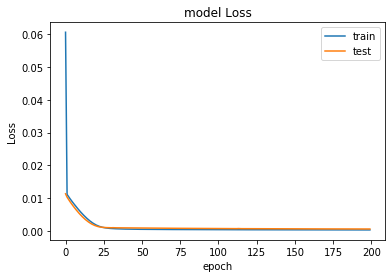

In [96]:
model_mlp = Model_Build('MLP', nodes_mlp, X_train_mlp, optimizer, learning_rate)
history_mlp = model_mlp.fit(X_train_mlp, Y_train_mlp, validation_split=validation_split, epochs=200, batch_size=batch_size, verbose=1, shuffle=False)
plt.plot(history_mlp.history['loss'])
plt.plot(history_mlp.history['val_loss'])
plt.title('model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

Train on 81 samples, validate on 27 samples
Epoch 1/70
81/81 [==============================] - 1s 7ms/step - loss: 0.0385 - accuracy: 0.0000e+00 - mse: 0.0385 - val_loss: 0.0685 - val_accuracy: 0.0000e+00 - val_mse: 0.0685
Epoch 2/70
81/81 [==============================] - 0s 635us/step - loss: 0.0109 - accuracy: 0.0000e+00 - mse: 0.0109 - val_loss: 0.0084 - val_accuracy: 0.0000e+00 - val_mse: 0.0084
Epoch 3/70
81/81 [==============================] - 0s 614us/step - loss: 0.0109 - accuracy: 0.0000e+00 - mse: 0.0109 - val_loss: 0.0069 - val_accuracy: 0.0000e+00 - val_mse: 0.0069
Epoch 4/70
81/81 [==============================] - 0s 711us/step - loss: 0.0099 - accuracy: 0.0000e+00 - mse: 0.0099 - val_loss: 0.0061 - val_accuracy: 0.0000e+00 - val_mse: 0.0061
Epoch 5/70
81/81 [==============================] - 0s 627us/step - loss: 0.0090 - accuracy: 0.0000e+00 - mse: 0.0090 - val_loss: 0.0054 - val_accuracy: 0.0000e+00 - val_mse: 0.0054
Epoch 6/70
81/81 [==============================

Epoch 44/70
81/81 [==============================] - 0s 495us/step - loss: 4.4577e-04 - accuracy: 0.0000e+00 - mse: 4.4577e-04 - val_loss: 8.4251e-04 - val_accuracy: 0.0000e+00 - val_mse: 8.4251e-04
Epoch 45/70
81/81 [==============================] - 0s 528us/step - loss: 4.4044e-04 - accuracy: 0.0000e+00 - mse: 4.4044e-04 - val_loss: 8.3702e-04 - val_accuracy: 0.0000e+00 - val_mse: 8.3702e-04
Epoch 46/70
81/81 [==============================] - 0s 480us/step - loss: 4.3542e-04 - accuracy: 0.0000e+00 - mse: 4.3542e-04 - val_loss: 8.3162e-04 - val_accuracy: 0.0000e+00 - val_mse: 8.3162e-04
Epoch 47/70
81/81 [==============================] - 0s 479us/step - loss: 4.3071e-04 - accuracy: 0.0000e+00 - mse: 4.3071e-04 - val_loss: 8.2652e-04 - val_accuracy: 0.0000e+00 - val_mse: 8.2652e-04
Epoch 48/70
81/81 [==============================] - 0s 464us/step - loss: 4.2609e-04 - accuracy: 0.0000e+00 - mse: 4.2609e-04 - val_loss: 8.2275e-04 - val_accuracy: 0.0000e+00 - val_mse: 8.2275e-04
Epoch

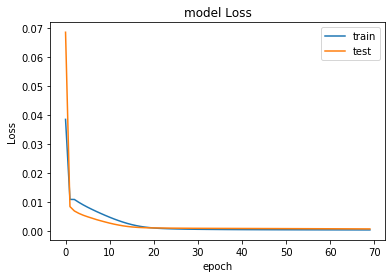

In [100]:
# 50 epochs are enough for training the model.
model_mlp = Model_Build('MLP', nodes_mlp, X_train_mlp, optimizer, learning_rate)
history_mlp = model_mlp.fit(X_train_mlp, Y_train_mlp, epochs=70,validation_split=validation_split, batch_size=batch_size, verbose=1, shuffle=False)
plt.plot(history_mlp.history['loss'])
plt.plot(history_mlp.history['val_loss'])
plt.title('model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

Saving/Loading Model:

In [104]:
model_mlp.save('/home/ahmada59/py/CO2Concentrations_MLP.h5')
# to load the model:
#model_mlp = load_model('/home/ahmada59/py/CO2Concentrations_MLP.h5')

We do one-step ahead recursive forecasting. X_test provides real values to the model for predicting. 

In [101]:
trainprediction_mlp = model_mlp.predict(X_train_mlp)
testprediction_mlp = model_mlp.predict(X_test_mlp)
trainprediction_mlp = pd.DataFrame(index=df.index[lag_mlp:len(df)-len(X_test_mlp)], data=trainprediction_mlp)
testprediction_mlp = pd.DataFrame(index=df.index[len(df)-len(X_test_mlp):], data=testprediction_mlp)

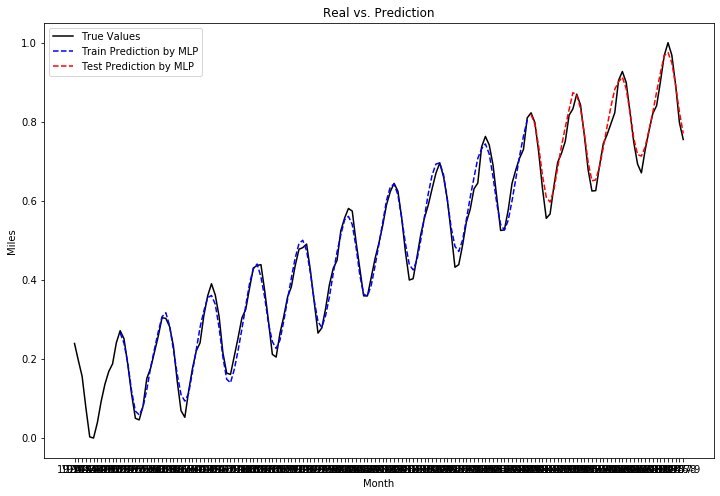

In [102]:
plt.figure(figsize=(12,8))
plt.plot(df.index, df.Concentrations, 'k')
plt.plot(trainprediction_mlp, '--b')
plt.plot(testprediction_mlp, '--r')
plt.title('Real vs. Prediction')
plt.ylabel('Miles')
plt.xlabel('Month')
plt.legend(['True Values', 'Train Prediction by MLP', 'Test Prediction by MLP'], loc='best')
plt.show()

In [103]:
Metrics['RMSE_MLP'] = RMSE(Y_test_mlp, testprediction_mlp)
Metrics['MAPE_MLP'] = MAPE(Y_test_mlp, testprediction_mlp)
Metrics['SMAPE_MLP'] = SMAPE(Y_test_mlp, testprediction_mlp)
Metrics['MSLE_MLP'] = MSLE(Y_test_mlp, testprediction_mlp)
Metrics

{'RMSE_SARIMA': 0.01423000301804426,
 'MAPE_SARIMA': 1.5865366875918112,
 'SMAPE_SARIMA': 1.5850406810996358,
 'MSLE_SARIMA': 6.433348881884668e-05,
 'RMSE_MLP': 0.023860435472015638,
 'MAPE_MLP': 15.789529849804262,
 'SMAPE_MLP': 624.6064294055852,
 'MSLE_MLP': 0.00018648175463270236,
 'RMSE_LSTM': 0.026695171271837473,
 'MAPE_LSTM': 16.31398017804951,
 'SMAPE_LSTM': 668.385481593327,
 'MSLE_LSTM': 0.00022751453604993963}

# Vanilla LSTM

LSTM  can be used for univariate and multivariate time series forecasting. 
The input to the first LSTM layer has this shape: [n_steps,n_features]. n_steps is the lag of the time series or
number of lags included for training the model.
and n_features is the number of features per time step. For univariate time series, n_features is equal to 1.
for multivariate time series it is equal to the number of features.
n_samples is the number of samples we feed into deep network.
All LSTM models can be used in this way.
Remember that The input for LSTMs must be three dimensional. where the thir dimention denotes number of features. the input is in this shape: [n_samples, n_steps, n_features]

In [10]:
def input_output_generator_LSTM(z,n):
    #generating input output sets for LSTM models
    x_train = []
    y_train = []
    x_test = []
    y_test = z[math.floor(trainfrac*len(z)):]
    z_train = z[:math.floor(trainfrac*len(z))]
    for i in range(len(z_train)-n):
        x_train.append(z[i:i+n])
        y_train.append(z[i+n])
    for i in range(len(y_test)):
        x_test.append(z[len(z_train)-n+i:len(z_train)+i])
    x_train = np.array(x_train)
    x_test = np.array(x_test)
    x_train_lstm = np.reshape(x_train,(x_train.shape[0], x_train.shape[1],1))
    x_test_lstm = np.reshape(x_test,(x_test.shape[0], x_test.shape[1],1))
    return x_train_lstm, np.array(y_train), x_test_lstm, np.array(y_test)

In [14]:
lag_lstm = 12
X_train_lstm, Y_train_lstm, X_test_lstm, Y_test_lstm = input_output_generator_LSTM(df['Concentrations'].tolist(),
                                                                                   lag_lstm)

In [657]:
#tuning optimizer. This can give us a good starting point.
opt = ['Adam', 'Adagrad', 'SGD', 'RMSprop', 'Adadelta']
lr = [0.001, 0.01, 0.1]
e = Tune_optimizer('Vanilla LSTM', X_train_lstm, Y_train_lstm, 50, validation_split, 50, 10, opt, lr)
optimizer = (min(e, key=e.get)).split(', ')[0]
learning_rate = float(((min(e, key=e.get)).split(', ')[1]).split('=')[1])
e

{'Adadelta, rate=0.001': 0.3692234456539154,
 'Adadelta, rate=0.01': 0.3080476864620491,
 'Adadelta, rate=0.1': 0.02570971253293532,
 'Adagrad, rate=0.001': 0.02321472329397996,
 'Adagrad, rate=0.01': 0.0683695767764692,
 'Adagrad, rate=0.1': 0.01006836751130996,
 'Adam, rate=0.001': 0.0024728528137698217,
 'Adam, rate=0.01': 0.0012493849283567182,
 'Adam, rate=0.1': 0.002473415681850855,
 'RMSprop, rate=0.001': 0.024906380653933243,
 'RMSprop, rate=0.01': 0.017857885195149317,
 'RMSprop, rate=0.1': 0.011803545368214449,
 'SGD, rate=0.001': 0.1331325399654883,
 'SGD, rate=0.01': 0.05325153635607825,
 'SGD, rate=0.1': 0.008101029321551323}

In [665]:
# tuning number of nodes in LSTM layer
nodes = [1, 10, 50, 100, 200]
e = Tune_nodes('Vanilla LSTM', X_train_lstm, Y_train_lstm, nodes, validation_split, 50, 10, optimizer, learning_rate)
nodes = int(min(e, key=e.get))

In [659]:
#tune batch size
batch = [1, 10, 30]
e = Tune_batch('Vanilla LSTM', X_train_lstm, Y_train_lstm, nodes, validation_split, 50,
               batch, optimizer, learning_rate)
batch_size = int(min(e, key=e.get))

Building the model:

In [26]:
nodes = 300
batch_size = 10
learning_rate = 0.01
optimizer = 'Adam'
model_lstm = Model_Build('Vanilla LSTM', nodes, X_train_lstm, optimizer, learning_rate)
model_lstm.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 300)               362400    
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 301       
Total params: 362,701
Trainable params: 362,701
Non-trainable params: 0
_________________________________________________________________


Train on 81 samples, validate on 27 samples
Epoch 1/100
81/81 [==============================] - 1s 6ms/step - loss: 0.0454 - accuracy: 0.0000e+00 - mse: 0.0454 - val_loss: 0.0170 - val_accuracy: 0.0000e+00 - val_mse: 0.0170
Epoch 2/100
81/81 [==============================] - 0s 2ms/step - loss: 0.0360 - accuracy: 0.0000e+00 - mse: 0.0360 - val_loss: 0.0478 - val_accuracy: 0.0000e+00 - val_mse: 0.0478
Epoch 3/100
81/81 [==============================] - 0s 2ms/step - loss: 0.0113 - accuracy: 0.0000e+00 - mse: 0.0113 - val_loss: 0.0088 - val_accuracy: 0.0000e+00 - val_mse: 0.0088
Epoch 4/100
81/81 [==============================] - 0s 2ms/step - loss: 0.0258 - accuracy: 0.0000e+00 - mse: 0.0258 - val_loss: 0.0359 - val_accuracy: 0.0000e+00 - val_mse: 0.0359
Epoch 5/100
81/81 [==============================] - 0s 2ms/step - loss: 0.0087 - accuracy: 0.0000e+00 - mse: 0.0087 - val_loss: 0.0086 - val_accuracy: 0.0000e+00 - val_mse: 0.0086
Epoch 6/100
81/81 [==============================] 

Epoch 87/100
81/81 [==============================] - 0s 2ms/step - loss: 4.2080e-04 - accuracy: 0.0000e+00 - mse: 4.2080e-04 - val_loss: 7.3208e-04 - val_accuracy: 0.0000e+00 - val_mse: 7.3208e-04
Epoch 88/100
81/81 [==============================] - 0s 2ms/step - loss: 7.9206e-04 - accuracy: 0.0000e+00 - mse: 7.9206e-04 - val_loss: 4.8241e-04 - val_accuracy: 0.0000e+00 - val_mse: 4.8241e-04
Epoch 89/100
81/81 [==============================] - 0s 2ms/step - loss: 3.1434e-04 - accuracy: 0.0000e+00 - mse: 3.1434e-04 - val_loss: 8.7765e-04 - val_accuracy: 0.0000e+00 - val_mse: 8.7765e-04
Epoch 90/100
81/81 [==============================] - 0s 2ms/step - loss: 8.0106e-04 - accuracy: 0.0000e+00 - mse: 8.0106e-04 - val_loss: 6.9855e-04 - val_accuracy: 0.0000e+00 - val_mse: 6.9855e-04
Epoch 91/100
81/81 [==============================] - 0s 2ms/step - loss: 7.5306e-04 - accuracy: 0.0000e+00 - mse: 7.5306e-04 - val_loss: 4.5817e-04 - val_accuracy: 0.0000e+00 - val_mse: 4.5817e-04
Epoch 92/1

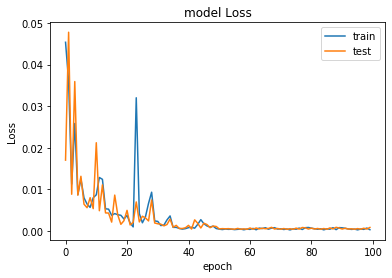

In [27]:
history_lstm = model_lstm.fit(X_train_lstm, Y_train_lstm, validation_split=validation_split, 
                              epochs=100, batch_size=batch_size, verbose=1, shuffle=False)
plt.plot(history_lstm.history['loss'])
plt.plot(history_lstm.history['val_loss'])
plt.title('model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

Train on 81 samples, validate on 27 samples
Epoch 1/50
81/81 [==============================] - 1s 9ms/step - loss: 0.1242 - accuracy: 0.0000e+00 - mse: 0.1242 - val_loss: 0.2138 - val_accuracy: 0.0000e+00 - val_mse: 0.2138
Epoch 2/50
81/81 [==============================] - 0s 6ms/step - loss: 0.0178 - accuracy: 0.0000e+00 - mse: 0.0178 - val_loss: 0.0366 - val_accuracy: 0.0000e+00 - val_mse: 0.0366
Epoch 3/50
81/81 [==============================] - 0s 6ms/step - loss: 0.0108 - accuracy: 0.0000e+00 - mse: 0.0108 - val_loss: 0.0081 - val_accuracy: 0.0000e+00 - val_mse: 0.0081
Epoch 4/50
81/81 [==============================] - 0s 5ms/step - loss: 0.0173 - accuracy: 0.0000e+00 - mse: 0.0173 - val_loss: 0.0159 - val_accuracy: 0.0000e+00 - val_mse: 0.0159
Epoch 5/50
81/81 [==============================] - 0s 5ms/step - loss: 0.0108 - accuracy: 0.0000e+00 - mse: 0.0108 - val_loss: 0.0093 - val_accuracy: 0.0000e+00 - val_mse: 0.0093
Epoch 6/50
81/81 [==============================] - 0s 5

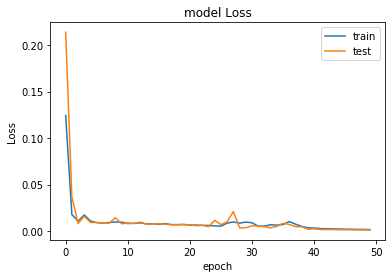

In [48]:
lag_lstm = 12
X_train_lstm, Y_train_lstm, X_test_lstm, Y_test_lstm = input_output_generator_LSTM(df['Concentrations'].tolist(),
                                                                                   lag_lstm)
model_lstm = Model_Build('Vanilla LSTM', nodes, X_train_lstm, optimizer, learning_rate)
history_lstm = model_lstm.fit(X_train_lstm, Y_train_lstm, validation_split=validation_split,
                              epochs=50, batch_size=batch_size, verbose=1, shuffle=False)
plt.plot(history_lstm.history['loss'])
plt.plot(history_lstm.history['val_loss'])
plt.title('model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

Saving/Loadin the model:

In [31]:
model_lstm.save('/home/ahmada59/py/CO2Concentrations_LSTM.h5')
# to load the model:
# model_lstm = load_model('/home/ahmada59/py/CO2Concentrations_LSTM.h5')

One-step ahead recursive forecasting:

In [28]:
trainprediction_lstm = model_lstm.predict(X_train_lstm)
testprediction_lstm = model_lstm.predict(X_test_lstm)
trainprediction_lstm = pd.DataFrame(index=df.index[lag_lstm:len(df)-len(X_test_lstm)], data=trainprediction_lstm)
testprediction_lstm = pd.DataFrame(index=df.index[len(df)-len(X_test_lstm):], data=testprediction_lstm)

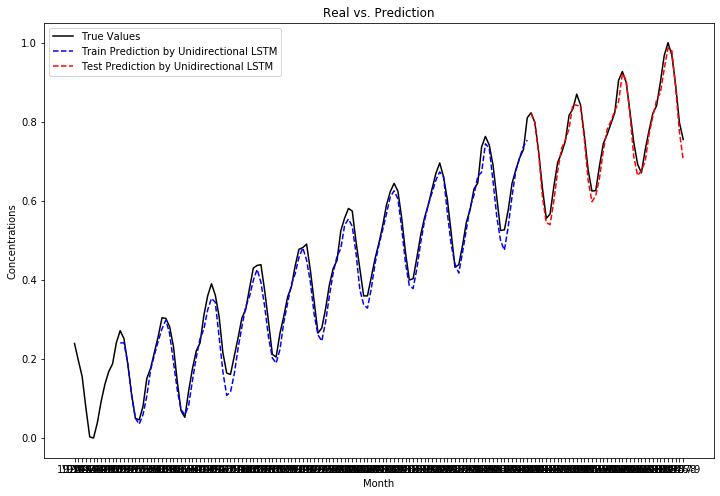

In [29]:
plt.figure(figsize=(12,8))
plt.plot(df.index, df.Concentrations, 'k')
plt.plot(trainprediction_lstm, '--b')
plt.plot(testprediction_lstm, '--r')
plt.title('Real vs. Prediction')
plt.ylabel('Concentrations')
plt.xlabel('Month')
plt.legend(['True Values', 'Train Prediction by Unidirectional LSTM', 'Test Prediction by Unidirectional LSTM']
           , loc='best')
plt.show()

In [32]:
Metrics['RMSE_LSTM'] = RMSE(Y_test_lstm, testprediction_lstm)
Metrics['MAPE_LSTM'] = MAPE(Y_test_lstm, testprediction_lstm)
Metrics['SMAPE_LSTM'] = SMAPE(Y_test_lstm, testprediction_lstm)
Metrics['MSLE_LSTM'] = MSLE(Y_test_lstm, testprediction_lstm)
Metrics

{'RMSE_SARIMA': 0.01423000301804426,
 'MAPE_SARIMA': 1.5865366875918112,
 'SMAPE_SARIMA': 1.5850406810996358,
 'MSLE_SARIMA': 6.433348881884668e-05,
 'RMSE_MLP': 0.023860435472015638,
 'MAPE_MLP': 15.789529849804262,
 'SMAPE_MLP': 624.6064294055852,
 'MSLE_MLP': 0.00018648175463270236,
 'RMSE_LSTM': 0.02233499336958177,
 'MAPE_LSTM': 16.443648692578037,
 'SMAPE_LSTM': 674.44300437793,
 'MSLE_LSTM': 0.00016366758312043311}

# Stacked Unidirectional LSTM

In [33]:
lag_sul = 12
X_train_sul, Y_train_sul, X_test_sul, Y_test_sul = input_output_generator_LSTM(df['Concentrations'].tolist(),
                                                                               lag_sul)

In [67]:
#tuning optimizer. This can give us a good starting point.
opt = ['Adam', 'Adagrad']
lr = [0.001, 0.1]
e = Tune_optimizer('Stacked Unidirectional LSTM', X_train_sul, Y_train_sul, [100, 100], validation_split, 50, 10, opt, lr)
optimizer = (min(e, key=e.get)).split(', ')[0]
learning_rate = float(((min(e, key=e.get)).split(', ')[1]).split('=')[1])
e

{'Adagrad, rate=0.001': 0.04647162101334996,
 'Adagrad, rate=0.1': 0.06227230059879797,
 'Adam, rate=0.001': 0.008022591626892487,
 'Adam, rate=0.1': 0.011763323995250242}

In [68]:
# tuning number of nodes in LSTM layer
nodes = [[10, 10], [50, 50], [100, 100]]
e = Tune_nodes('Stacked Unidirectional LSTM', X_train_sul, Y_train_sul, nodes, validation_split, 50, 10, optimizer, learning_rate)
e

{0: 0.00757092371996906, 1: 0.007861944588108195, 2: 0.01084009980506919}

In [68]:
nodes = [400, 400, 400]

In [70]:
#tune batch size
batch = [10, 30]
e = Tune_batch('Stacked Unidirectional LSTM', X_train_sul, Y_train_sul, nodes, validation_split, 50, batch, optimizer, learning_rate)
batch_size = int(min(e, key=e.get))
e

{10: 0.014708021517705035, 30: 0.033671483397483826}

Building the model:

In [67]:
nodes = [50,50]
optimizer = 'Adam'
learning_rate = 0.001
batch_size = 10
model_sul = Model_Build('Stacked Unidirectional LSTM', nodes, X_train_sul, optimizer, learning_rate)
model_sul.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_39 (LSTM)               (None, 12, 50)            10400     
_________________________________________________________________
lstm_40 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


Train on 81 samples, validate on 27 samples
Epoch 1/200
81/81 [==============================] - 1s 15ms/step - loss: 0.0896 - accuracy: 0.0000e+00 - mse: 0.0896 - val_loss: 0.2833 - val_accuracy: 0.0000e+00 - val_mse: 0.2833
Epoch 2/200
81/81 [==============================] - 0s 1ms/step - loss: 0.0703 - accuracy: 0.0000e+00 - mse: 0.0703 - val_loss: 0.2317 - val_accuracy: 0.0000e+00 - val_mse: 0.2317
Epoch 3/200
81/81 [==============================] - 0s 1ms/step - loss: 0.0413 - accuracy: 0.0000e+00 - mse: 0.0413 - val_loss: 0.1304 - val_accuracy: 0.0000e+00 - val_mse: 0.1304
Epoch 4/200
81/81 [==============================] - 0s 1ms/step - loss: 0.0124 - accuracy: 0.0000e+00 - mse: 0.0124 - val_loss: 0.0182 - val_accuracy: 0.0000e+00 - val_mse: 0.0182
Epoch 5/200
81/81 [==============================] - 0s 1ms/step - loss: 0.0377 - accuracy: 0.0000e+00 - mse: 0.0377 - val_loss: 0.0658 - val_accuracy: 0.0000e+00 - val_mse: 0.0658
Epoch 6/200
81/81 [==============================]

Epoch 90/200
81/81 [==============================] - 0s 843us/step - loss: 0.0025 - accuracy: 0.0000e+00 - mse: 0.0025 - val_loss: 0.0031 - val_accuracy: 0.0000e+00 - val_mse: 0.0031
Epoch 91/200
81/81 [==============================] - 0s 758us/step - loss: 0.0029 - accuracy: 0.0000e+00 - mse: 0.0029 - val_loss: 0.0027 - val_accuracy: 0.0000e+00 - val_mse: 0.0027
Epoch 92/200
81/81 [==============================] - 0s 844us/step - loss: 0.0031 - accuracy: 0.0000e+00 - mse: 0.0031 - val_loss: 0.0024 - val_accuracy: 0.0000e+00 - val_mse: 0.0024
Epoch 93/200
81/81 [==============================] - 0s 776us/step - loss: 0.0026 - accuracy: 0.0000e+00 - mse: 0.0026 - val_loss: 0.0031 - val_accuracy: 0.0000e+00 - val_mse: 0.0031
Epoch 94/200
81/81 [==============================] - 0s 864us/step - loss: 0.0047 - accuracy: 0.0000e+00 - mse: 0.0047 - val_loss: 0.0071 - val_accuracy: 0.0000e+00 - val_mse: 0.0071
Epoch 95/200
81/81 [==============================] - 0s 1ms/step - loss: 0.0054

81/81 [==============================] - 0s 953us/step - loss: 0.0021 - accuracy: 0.0000e+00 - mse: 0.0021 - val_loss: 0.0013 - val_accuracy: 0.0000e+00 - val_mse: 0.0013
Epoch 179/200
81/81 [==============================] - 0s 930us/step - loss: 0.0025 - accuracy: 0.0000e+00 - mse: 0.0025 - val_loss: 0.0034 - val_accuracy: 0.0000e+00 - val_mse: 0.0034
Epoch 180/200
81/81 [==============================] - 0s 799us/step - loss: 0.0037 - accuracy: 0.0000e+00 - mse: 0.0037 - val_loss: 0.0025 - val_accuracy: 0.0000e+00 - val_mse: 0.0025
Epoch 181/200
81/81 [==============================] - 0s 756us/step - loss: 0.0016 - accuracy: 0.0000e+00 - mse: 0.0016 - val_loss: 0.0019 - val_accuracy: 0.0000e+00 - val_mse: 0.0019
Epoch 182/200
81/81 [==============================] - 0s 824us/step - loss: 0.0035 - accuracy: 0.0000e+00 - mse: 0.0035 - val_loss: 0.0038 - val_accuracy: 0.0000e+00 - val_mse: 0.0038
Epoch 183/200
81/81 [==============================] - 0s 796us/step - loss: 0.0026 - acc

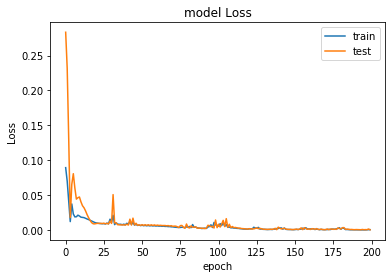

In [68]:
history_sul = model_sul.fit(X_train_sul, Y_train_sul, validation_split=validation_split, epochs=200,
                            batch_size=batch_size, verbose=1, shuffle=False)
plt.plot(history_sul.history['loss'])
plt.plot(history_sul.history['val_loss'])
plt.title('model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [ ]:
lag_sul = 12
X_train_sul, Y_train_sul, X_test_sul, Y_test_sul = input_output_generator_LSTM(df['Concentrations'].tolist(),
                                                                               lag_sul)
model_sul = Model_Build('Stacked Unidirectional LSTM', nodes, X_train_sul, optimizer, learning_rate)
history_sul = model_sul.fit(X_train_sul, Y_train_sul, validation_split=validation_split,
                            epochs=150, batch_size=batch_size, verbose=1, shuffle=False)
plt.plot(history_sul.history['loss'])
plt.plot(history_sul.history['val_loss'])
plt.title('model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

Saving/Loading the Model:

In [45]:
model_sul.save('/home/ahmada59/py/CO2Concentrations_SUL.h5')
# to load the model:
# model_sul = load_model('/home/ahmada59/py/CO2Concentrations_SUL.h5')

One-step ahead recursive forecasting:

In [69]:
trainprediction_sul = model_sul.predict(X_train_sul)
testprediction_sul = model_sul.predict(X_test_sul)
trainprediction_sul = pd.DataFrame(index=df.index[lag_sul:len(df)-len(X_test_sul)], data=trainprediction_sul)
testprediction_sul = pd.DataFrame(index=df.index[len(df)-len(X_test_sul):], data=testprediction_sul)

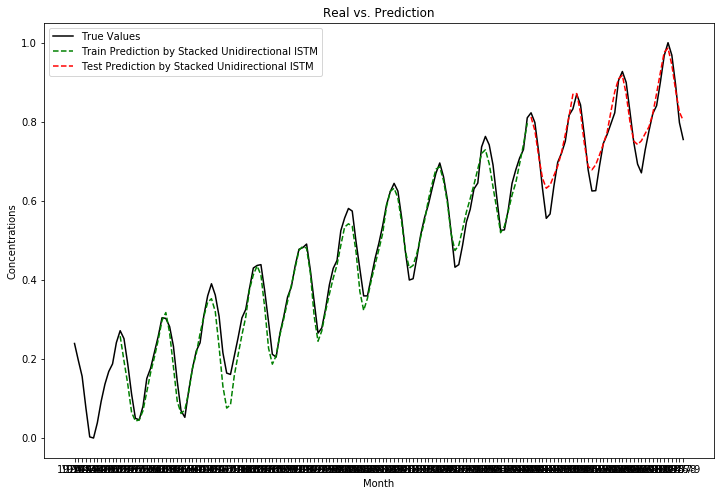

In [70]:
plt.figure(figsize=(12,8))
plt.plot(df.index, df.Concentrations, 'k')
plt.plot(trainprediction_sul, '--g')
plt.plot(testprediction_sul, '--r')
plt.title('Real vs. Prediction')
plt.ylabel('Concentrations')
plt.xlabel('Month')
plt.legend(['True Values', 'Train Prediction by Stacked Unidirectional lSTM', 'Test Prediction by Stacked Unidirectional lSTM'],
           loc='best')
plt.show()

In [71]:
Metrics['RMSE_SUL'] = RMSE(Y_test_sul, testprediction_sul)
Metrics['MAPE_SUL'] = MAPE(Y_test_sul, testprediction_sul)
Metrics['SMAPE_SUL'] = SMAPE(Y_test_sul, testprediction_sul)
Metrics['MSLE_SUL'] = MSLE(Y_test_sul, testprediction_sul)
Metrics

{'RMSE_SARIMA': 0.01423000301804426,
 'MAPE_SARIMA': 1.5865366875918112,
 'SMAPE_SARIMA': 1.5850406810996358,
 'MSLE_SARIMA': 6.433348881884668e-05,
 'RMSE_MLP': 0.023860435472015638,
 'MAPE_MLP': 15.789529849804262,
 'SMAPE_MLP': 624.6064294055852,
 'MSLE_MLP': 0.00018648175463270236,
 'RMSE_LSTM': 0.02233499336958177,
 'MAPE_LSTM': 16.443648692578037,
 'SMAPE_LSTM': 674.44300437793,
 'MSLE_LSTM': 0.00016366758312043311,
 'RMSE_SUL': 0.03341717551538441,
 'MAPE_SUL': 15.287985251891131,
 'SMAPE_SUL': 600.298397765347,
 'MSLE_SUL': 0.0003837868261487911}

# Bidirectional LSTM

In [116]:
lag_bl = 24
X_train_bl, Y_train_bl, X_test_bl, Y_test_bl = input_output_generator_LSTM(df['Concentrations'].tolist(), lag_bl)

In [160]:
#tuning optimizer. This can give us a good starting point.
opt = ['Adam', 'Adagrad']
lr = [0.001, 0.1]
e = Tune_optimizer('Bidirectional LSTM', X_train_bl, Y_train_bl, 50, validation_split, 50, 10, opt, lr)
optimizer = (min(e, key=e.get)).split(', ')[0]
learning_rate = float(((min(e, key=e.get)).split(', ')[1]).split('=')[1])
e

{'Adagrad, rate=0.001': 0.0414490106481093,
 'Adagrad, rate=0.1': 0.012001787122614958,
 'Adam, rate=0.001': 0.006569595697025458,
 'Adam, rate=0.1': 0.005236387890936048}

In [161]:
# tuning number of nodes in BLSTM layer
nodes = [50, 100, 200]
e = Tune_nodes('Bidirectional LSTM', X_train_bl, Y_train_bl, nodes, validation_split, 50, 10, optimizer, learning_rate)
nodes = int(min(e, key=e.get))

In [162]:
#tune batch size
batch = [10, 30]
e = Tune_batch('Bidirectional LSTM', X_train_bl, Y_train_bl, nodes, validation_split, 50, batch, optimizer, learning_rate)
batch_size = int(min(e, key=e.get))

building the model:

In [139]:
nodes = 300
learning_rate = 0.001
optimizer = 'Adam'
batch_size = 10
model_bl = Model_Build('Bidirectional LSTM', nodes, X_train_bl, optimizer, learning_rate)
model_bl.summary()

Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_20 (Bidirectio (None, 300)               724800    
_________________________________________________________________
dense_41 (Dense)             (None, 1)                 301       
Total params: 725,101
Trainable params: 725,101
Non-trainable params: 0
_________________________________________________________________


Train on 81 samples, validate on 27 samples
Epoch 1/300
81/81 [==============================] - 3s 36ms/step - loss: 0.0132 - accuracy: 0.0000e+00 - mse: 0.0132 - val_loss: 0.0098 - val_accuracy: 0.0000e+00 - val_mse: 0.0098
Epoch 2/300
81/81 [==============================] - 0s 4ms/step - loss: 0.0545 - accuracy: 0.0000e+00 - mse: 0.0545 - val_loss: 0.1208 - val_accuracy: 0.0000e+00 - val_mse: 0.1208
Epoch 3/300
81/81 [==============================] - 0s 3ms/step - loss: 0.0244 - accuracy: 0.0000e+00 - mse: 0.0244 - val_loss: 0.0914 - val_accuracy: 0.0000e+00 - val_mse: 0.0914
Epoch 4/300
81/81 [==============================] - 0s 4ms/step - loss: 0.0155 - accuracy: 0.0000e+00 - mse: 0.0155 - val_loss: 0.0430 - val_accuracy: 0.0000e+00 - val_mse: 0.0430
Epoch 5/300
81/81 [==============================] - 0s 4ms/step - loss: 0.0218 - accuracy: 0.0000e+00 - mse: 0.0218 - val_loss: 0.0416 - val_accuracy: 0.0000e+00 - val_mse: 0.0416
Epoch 6/300
81/81 [==============================]

Epoch 46/300
81/81 [==============================] - 0s 3ms/step - loss: 0.0031 - accuracy: 0.0000e+00 - mse: 0.0031 - val_loss: 0.0040 - val_accuracy: 0.0000e+00 - val_mse: 0.0040
Epoch 47/300
81/81 [==============================] - 0s 3ms/step - loss: 0.0026 - accuracy: 0.0000e+00 - mse: 0.0026 - val_loss: 0.0036 - val_accuracy: 0.0000e+00 - val_mse: 0.0036
Epoch 48/300
81/81 [==============================] - 0s 3ms/step - loss: 0.0041 - accuracy: 0.0000e+00 - mse: 0.0041 - val_loss: 0.0033 - val_accuracy: 0.0000e+00 - val_mse: 0.0033
Epoch 49/300
81/81 [==============================] - 0s 3ms/step - loss: 0.0023 - accuracy: 0.0000e+00 - mse: 0.0023 - val_loss: 0.0045 - val_accuracy: 0.0000e+00 - val_mse: 0.0045
Epoch 50/300
81/81 [==============================] - 0s 3ms/step - loss: 0.0019 - accuracy: 0.0000e+00 - mse: 0.0019 - val_loss: 0.0029 - val_accuracy: 0.0000e+00 - val_mse: 0.0029
Epoch 51/300
81/81 [==============================] - 0s 3ms/step - loss: 0.0020 - accurac

81/81 [==============================] - 0s 3ms/step - loss: 7.7862e-04 - accuracy: 0.0000e+00 - mse: 7.7862e-04 - val_loss: 8.8750e-04 - val_accuracy: 0.0000e+00 - val_mse: 8.8749e-04
Epoch 133/300
81/81 [==============================] - 0s 3ms/step - loss: 0.0017 - accuracy: 0.0000e+00 - mse: 0.0017 - val_loss: 0.0014 - val_accuracy: 0.0000e+00 - val_mse: 0.0014
Epoch 134/300
81/81 [==============================] - 0s 3ms/step - loss: 0.0022 - accuracy: 0.0000e+00 - mse: 0.0022 - val_loss: 0.0018 - val_accuracy: 0.0000e+00 - val_mse: 0.0018
Epoch 135/300
81/81 [==============================] - 0s 4ms/step - loss: 9.1083e-04 - accuracy: 0.0000e+00 - mse: 9.1083e-04 - val_loss: 8.5877e-04 - val_accuracy: 0.0000e+00 - val_mse: 8.5877e-04
Epoch 136/300
81/81 [==============================] - 0s 3ms/step - loss: 0.0010 - accuracy: 0.0000e+00 - mse: 0.0010 - val_loss: 0.0011 - val_accuracy: 0.0000e+00 - val_mse: 0.0011
Epoch 137/300
81/81 [==============================] - 0s 3ms/step 

81/81 [==============================] - 0s 4ms/step - loss: 3.7868e-04 - accuracy: 0.0000e+00 - mse: 3.7868e-04 - val_loss: 6.9163e-04 - val_accuracy: 0.0000e+00 - val_mse: 6.9163e-04
Epoch 215/300
81/81 [==============================] - 0s 3ms/step - loss: 4.4855e-04 - accuracy: 0.0000e+00 - mse: 4.4855e-04 - val_loss: 7.0579e-04 - val_accuracy: 0.0000e+00 - val_mse: 7.0579e-04
Epoch 216/300
81/81 [==============================] - 0s 3ms/step - loss: 4.0781e-04 - accuracy: 0.0000e+00 - mse: 4.0781e-04 - val_loss: 6.0584e-04 - val_accuracy: 0.0000e+00 - val_mse: 6.0584e-04
Epoch 217/300
81/81 [==============================] - 0s 3ms/step - loss: 3.9581e-04 - accuracy: 0.0000e+00 - mse: 3.9581e-04 - val_loss: 7.1256e-04 - val_accuracy: 0.0000e+00 - val_mse: 7.1256e-04
Epoch 218/300
81/81 [==============================] - 0s 3ms/step - loss: 4.9226e-04 - accuracy: 0.0000e+00 - mse: 4.9226e-04 - val_loss: 7.4230e-04 - val_accuracy: 0.0000e+00 - val_mse: 7.4230e-04
Epoch 219/300
81/81

81/81 [==============================] - 0s 4ms/step - loss: 5.8144e-04 - accuracy: 0.0000e+00 - mse: 5.8144e-04 - val_loss: 8.4371e-04 - val_accuracy: 0.0000e+00 - val_mse: 8.4371e-04
Epoch 297/300
81/81 [==============================] - 0s 4ms/step - loss: 5.5322e-04 - accuracy: 0.0000e+00 - mse: 5.5322e-04 - val_loss: 5.8188e-04 - val_accuracy: 0.0000e+00 - val_mse: 5.8188e-04
Epoch 298/300
81/81 [==============================] - 0s 4ms/step - loss: 5.3945e-04 - accuracy: 0.0000e+00 - mse: 5.3945e-04 - val_loss: 6.9596e-04 - val_accuracy: 0.0000e+00 - val_mse: 6.9596e-04
Epoch 299/300
81/81 [==============================] - 0s 3ms/step - loss: 7.5312e-04 - accuracy: 0.0000e+00 - mse: 7.5312e-04 - val_loss: 9.2531e-04 - val_accuracy: 0.0000e+00 - val_mse: 9.2531e-04
Epoch 300/300
81/81 [==============================] - 0s 3ms/step - loss: 5.9869e-04 - accuracy: 0.0000e+00 - mse: 5.9869e-04 - val_loss: 5.8320e-04 - val_accuracy: 0.0000e+00 - val_mse: 5.8320e-04


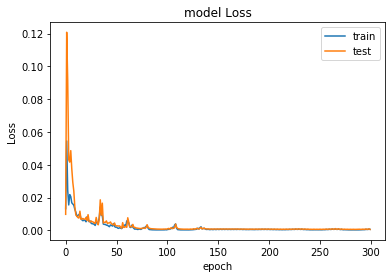

In [140]:
history_bl = model_bl.fit(X_train_bl, Y_train_bl, validation_split=validation_split, epochs=300, 
                          batch_size=batch_size, verbose=1, shuffle=False)
plt.plot(history_bl.history['loss'])
plt.plot(history_bl.history['val_loss'])
plt.title('model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

Train on 81 samples, validate on 27 samples
Epoch 1/100
81/81 [==============================] - 3s 31ms/step - loss: 0.0708 - accuracy: 0.0000e+00 - mse: 0.0708 - val_loss: 0.1673 - val_accuracy: 0.0000e+00 - val_mse: 0.1673
Epoch 2/100
81/81 [==============================] - 0s 2ms/step - loss: 0.0136 - accuracy: 0.0000e+00 - mse: 0.0136 - val_loss: 0.0291 - val_accuracy: 0.0000e+00 - val_mse: 0.0291
Epoch 3/100
81/81 [==============================] - 0s 2ms/step - loss: 0.0244 - accuracy: 0.0000e+00 - mse: 0.0244 - val_loss: 0.0454 - val_accuracy: 0.0000e+00 - val_mse: 0.0454
Epoch 4/100
81/81 [==============================] - 0s 1ms/step - loss: 0.0181 - accuracy: 0.0000e+00 - mse: 0.0181 - val_loss: 0.0438 - val_accuracy: 0.0000e+00 - val_mse: 0.0438
Epoch 5/100
81/81 [==============================] - 0s 1ms/step - loss: 0.0161 - accuracy: 0.0000e+00 - mse: 0.0161 - val_loss: 0.0337 - val_accuracy: 0.0000e+00 - val_mse: 0.0337
Epoch 6/100
81/81 [==============================]

Epoch 46/100
81/81 [==============================] - 0s 2ms/step - loss: 0.0045 - accuracy: 0.0000e+00 - mse: 0.0045 - val_loss: 0.0044 - val_accuracy: 0.0000e+00 - val_mse: 0.0044
Epoch 47/100
81/81 [==============================] - 0s 1ms/step - loss: 0.0043 - accuracy: 0.0000e+00 - mse: 0.0043 - val_loss: 0.0041 - val_accuracy: 0.0000e+00 - val_mse: 0.0041
Epoch 48/100
81/81 [==============================] - 0s 1ms/step - loss: 0.0041 - accuracy: 0.0000e+00 - mse: 0.0041 - val_loss: 0.0037 - val_accuracy: 0.0000e+00 - val_mse: 0.0037
Epoch 49/100
81/81 [==============================] - 0s 1ms/step - loss: 0.0037 - accuracy: 0.0000e+00 - mse: 0.0037 - val_loss: 0.0034 - val_accuracy: 0.0000e+00 - val_mse: 0.0034
Epoch 50/100
81/81 [==============================] - 0s 1ms/step - loss: 0.0033 - accuracy: 0.0000e+00 - mse: 0.0033 - val_loss: 0.0030 - val_accuracy: 0.0000e+00 - val_mse: 0.0030
Epoch 51/100
81/81 [==============================] - 0s 1ms/step - loss: 0.0029 - accurac

Epoch 91/100
81/81 [==============================] - 0s 2ms/step - loss: 0.0013 - accuracy: 0.0000e+00 - mse: 0.0013 - val_loss: 0.0016 - val_accuracy: 0.0000e+00 - val_mse: 0.0016
Epoch 92/100
81/81 [==============================] - 0s 1ms/step - loss: 9.2001e-04 - accuracy: 0.0000e+00 - mse: 9.2001e-04 - val_loss: 0.0017 - val_accuracy: 0.0000e+00 - val_mse: 0.0017
Epoch 93/100
81/81 [==============================] - 0s 1ms/step - loss: 6.9220e-04 - accuracy: 0.0000e+00 - mse: 6.9220e-04 - val_loss: 0.0013 - val_accuracy: 0.0000e+00 - val_mse: 0.0013
Epoch 94/100
81/81 [==============================] - 0s 1ms/step - loss: 0.0012 - accuracy: 0.0000e+00 - mse: 0.0012 - val_loss: 0.0015 - val_accuracy: 0.0000e+00 - val_mse: 0.0015
Epoch 95/100
81/81 [==============================] - 0s 1ms/step - loss: 9.4537e-04 - accuracy: 0.0000e+00 - mse: 9.4537e-04 - val_loss: 0.0014 - val_accuracy: 0.0000e+00 - val_mse: 0.0014
Epoch 96/100
81/81 [==============================] - 0s 1ms/step 

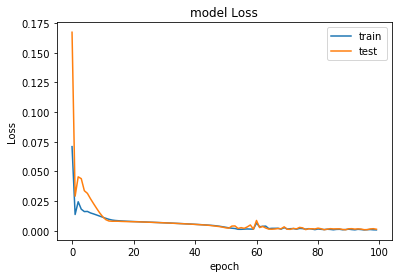

In [122]:
lag_bl = 12
X_train_bl, Y_train_bl, X_test_bl, Y_test_bl = input_output_generator_LSTM(df['Concentrations'].tolist(), lag_bl)
model_bl = Model_Build('Bidirectional LSTM', nodes, X_train_bl, optimizer, learning_rate)
history_bl = model_bl.fit(X_train_bl, Y_train_bl, validation_split=validation_split, epochs=100,
                          batch_size=batch_size, verbose=1, shuffle=False)
plt.plot(history_bl.history['loss'])
plt.plot(history_bl.history['val_loss'])
plt.title('model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

Saving/Loading the model:

In [145]:
model_bl.save('/home/ahmada59/py/CO2Concentrations_BL.h5')
# to load the model:
# model_bl = load_model('/home/ahmada59/py/CO2Concentrations_BL.h5')

One-step ahead recursive forecasting:

In [146]:
trainprediction_bl = model_bl.predict(X_train_bl)
testprediction_bl = model_bl.predict(X_test_bl)
trainprediction_bl = pd.DataFrame(index=df.index[lag_bl:len(df)-len(X_test_bl)], data=trainprediction_bl)
testprediction_bl = pd.DataFrame(index=df.index[len(df)-len(X_test_bl):], data=testprediction_bl)

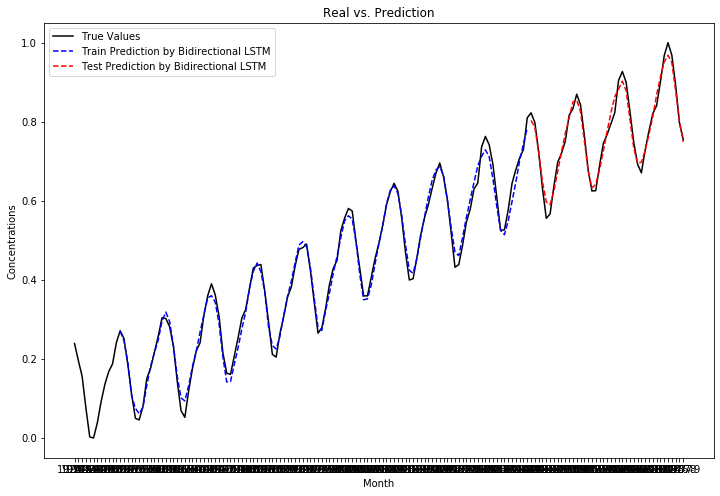

In [147]:
plt.figure(figsize=(12,8))
plt.plot(df.index, df.Concentrations, 'k')
plt.plot(trainprediction_bl, '--b')
plt.plot(testprediction_bl, '--r')
plt.title('Real vs. Prediction')
plt.ylabel('Concentrations')
plt.xlabel('Month')
plt.legend(['True Values', 'Train Prediction by Bidirectional LSTM', 'Test Prediction by Bidirectional LSTM'],
           loc='best')
plt.show()

In [149]:
Metrics['RMSE_BL'] = RMSE(Y_test_bl, testprediction_bl)
Metrics['MAPE_BL'] = MAPE(Y_test_bl, testprediction_bl)
Metrics['SMAPE_BL'] = SMAPE(Y_test_bl, testprediction_bl)
Metrics['MSLE_BL'] = MSLE(Y_test_bl, testprediction_bl)
Metrics

{'RMSE_SARIMA': 0.01423000301804426,
 'MAPE_SARIMA': 1.5865366875918112,
 'SMAPE_SARIMA': 1.5850406810996358,
 'MSLE_SARIMA': 6.433348881884668e-05,
 'RMSE_MLP': 0.023860435472015638,
 'MAPE_MLP': 15.789529849804262,
 'SMAPE_MLP': 624.6064294055852,
 'MSLE_MLP': 0.00018648175463270236,
 'RMSE_LSTM': 0.02233499336958177,
 'MAPE_LSTM': 16.443648692578037,
 'SMAPE_LSTM': 674.44300437793,
 'MSLE_LSTM': 0.00016366758312043311,
 'RMSE_SUL': 0.03341717551538441,
 'MAPE_SUL': 15.287985251891131,
 'SMAPE_SUL': 600.298397765347,
 'MSLE_SUL': 0.0003837868261487911,
 'RMSE_BL': 0.018727167063783023,
 'MAPE_BL': 15.61053999851306,
 'SMAPE_BL': 628.0273774037925,
 'MSLE_BL': 0.00011168522837371326}

# Stacked Bidirectional LSTM

In [210]:
lag_sbl = 12
X_train_sbl, Y_train_sbl, X_test_sbl, Y_test_sbl = input_output_generator_LSTM(df['Concentrations'].tolist(),
                                                                               lag_sbl)

In [41]:
#tuning optimizer. This can give us a good starting point.
opt = ['Adam', 'Adagrad']
lr = [0.001, 0.1]
e = Tune_optimizer('Stacked Bidirectional LSTM', X_train_sbl, Y_train_sbl, [50, 50], validation_split, 50, 10, opt, lr)
optimizer = (min(e, key=e.get)).split(', ')[0]
learning_rate = float(((min(e, key=e.get)).split(', ')[1]).split('=')[1])
e

{'Adagrad, rate=0.001': 0.04876123492916425,
 'Adagrad, rate=0.1': 0.010471378935983888,
 'Adam, rate=0.001': 0.00507569204395016,
 'Adam, rate=0.1': 0.0006934339719548545}

In [43]:
# tuning number of nodes in BLSTM layer
nodes = [[50, 50], [100, 100], [200, 200]]
e = Tune_nodes('Stacked Bidirectional LSTM', X_train_sbl, Y_train_sbl, nodes, validation_split, 50, 10, optimizer, learning_rate)
e

{0: 0.017551523460834113, 1: nan, 2: nan}

In [45]:
nodes = [50, 50]

In [46]:
#tune batch size
batch = [10, 30]
e = Tune_batch('Stacked Bidirectional LSTM', X_train_sbl, Y_train_sbl, nodes, validation_split, 50, batch, optimizer, learning_rate)
batch_size = int(min(e, key=e.get))

Building the model:

In [217]:
nodes = [100, 100]
batch_size = 10
optimizer = 'Adam'
learning_rate = 0.01
model_sbl = Model_Build('Stacked Bidirectional LSTM', nodes, X_train_sbl, optimizer, learning_rate)
model_sbl.summary()

Model: "sequential_73"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_88 (Bidirectio (None, 12, 100)           81600     
_________________________________________________________________
bidirectional_89 (Bidirectio (None, 100)               160800    
_________________________________________________________________
dense_73 (Dense)             (None, 1)                 101       
Total params: 242,501
Trainable params: 242,501
Non-trainable params: 0
_________________________________________________________________


Train on 81 samples, validate on 27 samples
Epoch 1/150
81/81 [==============================] - 7s 92ms/step - loss: 0.0761 - accuracy: 0.0000e+00 - mse: 0.0761 - val_loss: 0.2576 - val_accuracy: 0.0000e+00 - val_mse: 0.2576
Epoch 2/150
81/81 [==============================] - 0s 2ms/step - loss: 0.0481 - accuracy: 0.0000e+00 - mse: 0.0481 - val_loss: 0.0843 - val_accuracy: 0.0000e+00 - val_mse: 0.0843
Epoch 3/150
81/81 [==============================] - 0s 2ms/step - loss: 0.0260 - accuracy: 0.0000e+00 - mse: 0.0260 - val_loss: 0.0637 - val_accuracy: 0.0000e+00 - val_mse: 0.0637
Epoch 4/150
81/81 [==============================] - 0s 3ms/step - loss: 0.0278 - accuracy: 0.0000e+00 - mse: 0.0278 - val_loss: 0.0758 - val_accuracy: 0.0000e+00 - val_mse: 0.0758
Epoch 5/150
81/81 [==============================] - 0s 2ms/step - loss: 0.0237 - accuracy: 0.0000e+00 - mse: 0.0237 - val_loss: 0.0705 - val_accuracy: 0.0000e+00 - val_mse: 0.0705
Epoch 6/150
81/81 [==============================]

Epoch 46/150
81/81 [==============================] - 0s 2ms/step - loss: 0.0039 - accuracy: 0.0000e+00 - mse: 0.0039 - val_loss: 0.0063 - val_accuracy: 0.0000e+00 - val_mse: 0.0063
Epoch 47/150
81/81 [==============================] - 0s 2ms/step - loss: 0.0036 - accuracy: 0.0000e+00 - mse: 0.0036 - val_loss: 0.0068 - val_accuracy: 0.0000e+00 - val_mse: 0.0068
Epoch 48/150
81/81 [==============================] - 0s 2ms/step - loss: 0.0035 - accuracy: 0.0000e+00 - mse: 0.0035 - val_loss: 0.0048 - val_accuracy: 0.0000e+00 - val_mse: 0.0048
Epoch 49/150
81/81 [==============================] - 0s 2ms/step - loss: 0.0029 - accuracy: 0.0000e+00 - mse: 0.0029 - val_loss: 0.0048 - val_accuracy: 0.0000e+00 - val_mse: 0.0048
Epoch 50/150
81/81 [==============================] - 0s 2ms/step - loss: 0.0026 - accuracy: 0.0000e+00 - mse: 0.0026 - val_loss: 0.0055 - val_accuracy: 0.0000e+00 - val_mse: 0.0055
Epoch 51/150
81/81 [==============================] - 0s 2ms/step - loss: 0.0037 - accurac

81/81 [==============================] - 0s 2ms/step - loss: 3.3503e-04 - accuracy: 0.0000e+00 - mse: 3.3503e-04 - val_loss: 0.0011 - val_accuracy: 0.0000e+00 - val_mse: 0.0011
Epoch 134/150
81/81 [==============================] - 0s 2ms/step - loss: 5.7482e-04 - accuracy: 0.0000e+00 - mse: 5.7482e-04 - val_loss: 0.0011 - val_accuracy: 0.0000e+00 - val_mse: 0.0011
Epoch 135/150
81/81 [==============================] - 0s 2ms/step - loss: 4.7621e-04 - accuracy: 0.0000e+00 - mse: 4.7621e-04 - val_loss: 0.0012 - val_accuracy: 0.0000e+00 - val_mse: 0.0012
Epoch 136/150
81/81 [==============================] - 0s 3ms/step - loss: 3.4327e-04 - accuracy: 0.0000e+00 - mse: 3.4327e-04 - val_loss: 0.0012 - val_accuracy: 0.0000e+00 - val_mse: 0.0012
Epoch 137/150
81/81 [==============================] - 0s 3ms/step - loss: 4.9515e-04 - accuracy: 0.0000e+00 - mse: 4.9515e-04 - val_loss: 9.9193e-04 - val_accuracy: 0.0000e+00 - val_mse: 9.9193e-04
Epoch 138/150
81/81 [==============================

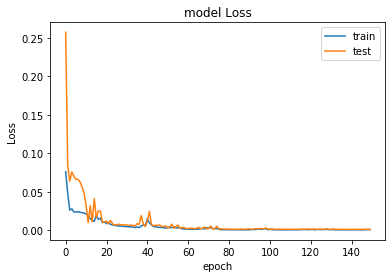

In [218]:
history_sbl = model_sbl.fit(X_train_sbl, Y_train_sbl, validation_split=validation_split, epochs=150,
                            batch_size=batch_size, verbose=1, shuffle=False)
plt.plot(history_sbl.history['loss'])
plt.plot(history_sbl.history['val_loss'])
plt.title('model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [ ]:
lag_sbl = 12
X_train_sbl, Y_train_sbl, X_test_sbl, Y_test_sbl = input_output_generator_LSTM(df['Concentrations'].tolist(),
                                                                               lag_sbl)
model_sbl = Model_Build('Stacked Bidirectional LSTM', nodes, X_train_sbl, optimizer, 0.001)
history_sbl = model_sbl.fit(X_train_sbl, Y_train_sbl, validation_split=validation_split, epochs=80,
                            batch_size=batch_size, verbose=1, shuffle=False)
print(history_sbl.history.keys())
plt.plot(history_sbl.history['loss'])
plt.plot(history_sbl.history['val_loss'])
plt.title('model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

saving/loading the model:

In [222]:
model_sbl.save('/home/ahmada59/py/CO2Concentrations_SBL.h5')
# to load the model:
# model_sbl = load_model('/home/ahmada59/py/CO2Concentrations_SBL.h5')

Forecast:

In [219]:
trainprediction_sbl = model_sbl.predict(X_train_sbl)
testprediction_sbl = model_sbl.predict(X_test_sbl)
trainprediction_sbl = pd.DataFrame(index=df.index[lag_sbl:len(df)-len(X_test_sbl)], data=trainprediction_sbl)
testprediction_sbl = pd.DataFrame(index=df.index[len(df)-len(X_test_sbl):], data=testprediction_sbl)

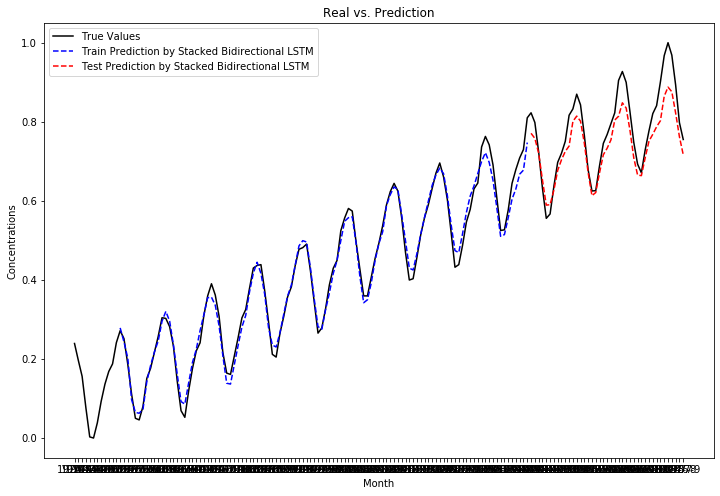

In [220]:
plt.figure(figsize=(12,8))
plt.plot(df.index, df.Concentrations, 'k')
plt.plot(trainprediction_sbl, '--b')
plt.plot(testprediction_sbl, '--r')
plt.title('Real vs. Prediction')
plt.ylabel('Concentrations')
plt.xlabel('Month')
plt.legend(['True Values', 'Train Prediction by Stacked Bidirectional LSTM',
            'Test Prediction by Stacked Bidirectional LSTM'], loc='best')
plt.show()

In [221]:
Metrics['RMSE_SBL'] = RMSE(Y_test_sbl, testprediction_sbl)
Metrics['MAPE_SBL'] = MAPE(Y_test_sbl, testprediction_sbl)
Metrics['SMAPE_SBL'] = SMAPE(Y_test_sbl, testprediction_sbl)
Metrics['MSLE_SBL'] = MSLE(Y_test_sbl, testprediction_sbl)
Metrics

{'RMSE_SARIMA': 0.01423000301804426,
 'MAPE_SARIMA': 1.5865366875918112,
 'SMAPE_SARIMA': 1.5850406810996358,
 'MSLE_SARIMA': 6.433348881884668e-05,
 'RMSE_MLP': 0.023860435472015638,
 'MAPE_MLP': 15.789529849804262,
 'SMAPE_MLP': 624.6064294055852,
 'MSLE_MLP': 0.00018648175463270236,
 'RMSE_LSTM': 0.02233499336958177,
 'MAPE_LSTM': 16.443648692578037,
 'SMAPE_LSTM': 674.44300437793,
 'MSLE_LSTM': 0.00016366758312043311,
 'RMSE_SUL': 0.03341717551538441,
 'MAPE_SUL': 15.287985251891131,
 'SMAPE_SUL': 600.298397765347,
 'MSLE_SUL': 0.0003837868261487911,
 'RMSE_BL': 0.018727167063783023,
 'MAPE_BL': 15.61053999851306,
 'SMAPE_BL': 628.0273774037925,
 'MSLE_BL': 0.00011168522837371326,
 'RMSE_SBL': 0.05030619285406642,
 'MAPE_SBL': 14.203796650434985,
 'SMAPE_SBL': 597.835927799143,
 'MSLE_SBL': 0.0007449517807820243}

# CNN-LSTM

CNN-LSTM is composed of conv1d layers and maxpooling on input data followed by stacked LSTM layers. the conv1D
layer tries to learn and extract the features according to the filters. 
The input to the CNN has the following shape: [samples, subsequences, timesteps, features]. 


Number of features is determined by number of features in time series. if it is univariate, n_features is equal to 1. number of subsequences is actually number of subsequences in a sequence. If each input has 10 timesteps in it for instance, it could be 1 sequence or we can divide it in 2 subsequences with 5 timesteps. 


In [17]:
def input_output_generator_CNNLSTM(z,n,n_seq):
    #generating input output sets for LSTM models
    x_train = []
    y_train = []
    x_test = []
    y_test = z[math.floor(trainfrac*len(z)):]
    z_train = z[:math.floor(trainfrac*len(z))]
    for i in range(len(z_train)-n):
        x_train.append(z[i:i+n])
        y_train.append(z[i+n])
    for i in range(len(y_test)):
        x_test.append(z[len(z_train)-n+i:len(z_train)+i])
    x_train = np.array(x_train)
    x_test = np.array(x_test)
    x_train_cnnlstm = np.reshape(x_train,(x_train.shape[0], n_seq, x_train.shape[1],1))
    x_test_cnnlstm = np.reshape(x_test,(x_test.shape[0], n_seq, x_test.shape[1],1))
    return x_train_cnnlstm, np.array(y_train), x_test_cnnlstm, np.array(y_test)

In [182]:
n_seq = 1
lag_clstm = 12
X_train_clstm, Y_train_clstm, X_test_clstm, Y_test_clstm = input_output_generator_CNNLSTM(df['Concentrations'].tolist(),
                                                                                          lag_clstm, n_seq)

In [47]:
#tuning optimizer. This can give us a good starting point.
opt = ['Adam', 'Adagrad']
lr = [0.001, 0.1]
e = Tune_optimizer('CNN-LSTM', X_train_clstm, Y_train_clstm, [50, 50], validation_split, 50, 10, opt, lr)
optimizer = (min(e, key=e.get)).split(', ')[0]
learning_rate = float(((min(e, key=e.get)).split(', ')[1]).split('=')[1])
e

{'Adagrad, rate=0.001': 3.3001989876782454,
 'Adagrad, rate=0.1': 1.9756460233970925,
 'Adam, rate=0.001': 0.4918220556444592,
 'Adam, rate=0.1': 0.06776960966763673}

In [48]:
# tuning number of nodes in BLSTM layer
nodes = [[50, 50], [100, 100], [200, 200]]
e = Tune_nodes('CNN-LSTM', X_train_clstm, Y_train_clstm, nodes, validation_split, 50, 10, optimizer, learning_rate)
e

{0: 0.39939527048004997, 1: 0.06814188648153234, 2: 0.39939527048004997}

In [60]:
#tune batch size
batch = [10, 30]
e = Tune_batch('CNN-LSTM', X_train_clstm, Y_train_clstm, nodes, validation_split, 50, batch, optimizer, learning_rate)
batch_size = int(min(e, key=e.get))

In [244]:
nodes = 600
learning_rate = 0.001
optimizer = 'Adam'
batch_size = 5
model_clstm = Model_Build('CNN-LSTM', nodes, X_train_clstm, optimizer, learning_rate)
model_clstm.summary()

Model: "sequential_72"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_268 (TimeDi (None, 1, 12, 8)          24        
_________________________________________________________________
time_distributed_269 (TimeDi (None, 1, 6, 8)           0         
_________________________________________________________________
time_distributed_270 (TimeDi (None, 1, 6, 8)           136       
_________________________________________________________________
time_distributed_271 (TimeDi (None, 1, 3, 8)           0         
_________________________________________________________________
time_distributed_272 (TimeDi (None, 1, 24)             0         
_________________________________________________________________
lstm_72 (LSTM)               (None, 600)               1500000   
_________________________________________________________________
dropout_72 (Dropout)         (None, 600)             

Train on 81 samples, validate on 27 samples
Epoch 1/100
81/81 [==============================] - 4s 47ms/step - loss: 0.0866 - accuracy: 0.0000e+00 - mse: 0.0866 - val_loss: 0.1486 - val_accuracy: 0.0000e+00 - val_mse: 0.1486
Epoch 2/100
81/81 [==============================] - 0s 3ms/step - loss: 0.0088 - accuracy: 0.0000e+00 - mse: 0.0088 - val_loss: 0.0061 - val_accuracy: 0.0000e+00 - val_mse: 0.0061
Epoch 3/100
81/81 [==============================] - 0s 3ms/step - loss: 0.0137 - accuracy: 0.0000e+00 - mse: 0.0137 - val_loss: 0.0156 - val_accuracy: 0.0000e+00 - val_mse: 0.0156
Epoch 4/100
81/81 [==============================] - 0s 3ms/step - loss: 0.0079 - accuracy: 0.0000e+00 - mse: 0.0079 - val_loss: 0.0091 - val_accuracy: 0.0000e+00 - val_mse: 0.0091
Epoch 5/100
81/81 [==============================] - 0s 3ms/step - loss: 0.0077 - accuracy: 0.0000e+00 - mse: 0.0077 - val_loss: 0.0064 - val_accuracy: 0.0000e+00 - val_mse: 0.0064
Epoch 6/100
81/81 [==============================]

81/81 [==============================] - 0s 3ms/step - loss: 0.0011 - accuracy: 0.0000e+00 - mse: 0.0011 - val_loss: 0.0011 - val_accuracy: 0.0000e+00 - val_mse: 0.0011
Epoch 87/100
81/81 [==============================] - 0s 3ms/step - loss: 6.0192e-04 - accuracy: 0.0000e+00 - mse: 6.0192e-04 - val_loss: 6.4424e-04 - val_accuracy: 0.0000e+00 - val_mse: 6.4424e-04
Epoch 88/100
81/81 [==============================] - 0s 3ms/step - loss: 9.7626e-04 - accuracy: 0.0000e+00 - mse: 9.7626e-04 - val_loss: 5.5463e-04 - val_accuracy: 0.0000e+00 - val_mse: 5.5463e-04
Epoch 89/100
81/81 [==============================] - 0s 3ms/step - loss: 0.0011 - accuracy: 0.0000e+00 - mse: 0.0011 - val_loss: 0.0013 - val_accuracy: 0.0000e+00 - val_mse: 0.0013
Epoch 90/100
81/81 [==============================] - 0s 3ms/step - loss: 0.0013 - accuracy: 0.0000e+00 - mse: 0.0013 - val_loss: 0.0011 - val_accuracy: 0.0000e+00 - val_mse: 0.0011
Epoch 91/100
81/81 [==============================] - 0s 3ms/step - los

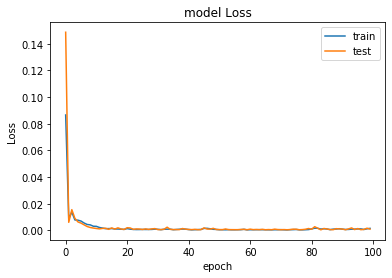

In [245]:
history_clstm = model_clstm.fit(X_train_clstm, Y_train_clstm, validation_split=validation_split,
                                epochs=100, batch_size=batch_size, verbose=1, shuffle=False)
plt.plot(history_clstm.history['loss'])
plt.plot(history_clstm.history['val_loss'])
plt.title('model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

Train on 81 samples, validate on 27 samples
Epoch 1/40
81/81 [==============================] - 3s 37ms/step - loss: 0.1092 - accuracy: 0.0000e+00 - mse: 0.1092 - val_loss: 0.2534 - val_accuracy: 0.0000e+00 - val_mse: 0.2534
Epoch 2/40
81/81 [==============================] - 0s 2ms/step - loss: 0.0320 - accuracy: 0.0000e+00 - mse: 0.0320 - val_loss: 0.0308 - val_accuracy: 0.0000e+00 - val_mse: 0.0308
Epoch 3/40
81/81 [==============================] - 0s 2ms/step - loss: 0.0137 - accuracy: 0.0000e+00 - mse: 0.0137 - val_loss: 0.0131 - val_accuracy: 0.0000e+00 - val_mse: 0.0131
Epoch 4/40
81/81 [==============================] - 0s 2ms/step - loss: 0.0143 - accuracy: 0.0000e+00 - mse: 0.0143 - val_loss: 0.0236 - val_accuracy: 0.0000e+00 - val_mse: 0.0236
Epoch 5/40
81/81 [==============================] - 0s 3ms/step - loss: 0.0111 - accuracy: 0.0000e+00 - mse: 0.0111 - val_loss: 0.0144 - val_accuracy: 0.0000e+00 - val_mse: 0.0144
Epoch 6/40
81/81 [==============================] - 0s 

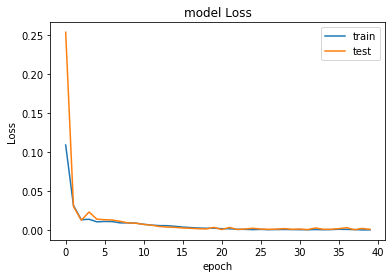

In [188]:
lag_clstm = 12
X_train_clstm, Y_train_clstm, X_test_clstm, Y_test_clstm = input_output_generator_CNNLSTM(df['Concentrations'].tolist(),
                                                                                          lag_clstm, n_seq)
model_clstm = Model_Build('CNN-LSTM', nodes, X_train_clstm, optimizer, learning_rate)
history_clstm = model_clstm.fit(X_train_clstm, Y_train_clstm, validation_split=validation_split, epochs=40,
                                batch_size=batch_size, verbose=1, shuffle=False)
plt.plot(history_clstm.history['loss'])
plt.plot(history_clstm.history['val_loss'])
plt.title('model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

saving/loading the model:

In [249]:
model_clstm.save('/home/ahmada59/py/CO2Concentrations_CLSTM.h5')
# to load the model:
# model_clstm = load_model('/home/ahmada59/py/CO2Concentrations_CLSTM.h5')

Forecasting:

In [246]:
trainprediction_clstm = model_clstm.predict(X_train_clstm)
testprediction_clstm = model_clstm.predict(X_test_clstm)
trainprediction_clstm = pd.DataFrame(index=df.index[lag_clstm:len(df)-len(X_test_clstm)], data=trainprediction_clstm)
testprediction_clstm = pd.DataFrame(index=df.index[len(df)-len(X_test_clstm):], data=testprediction_clstm)

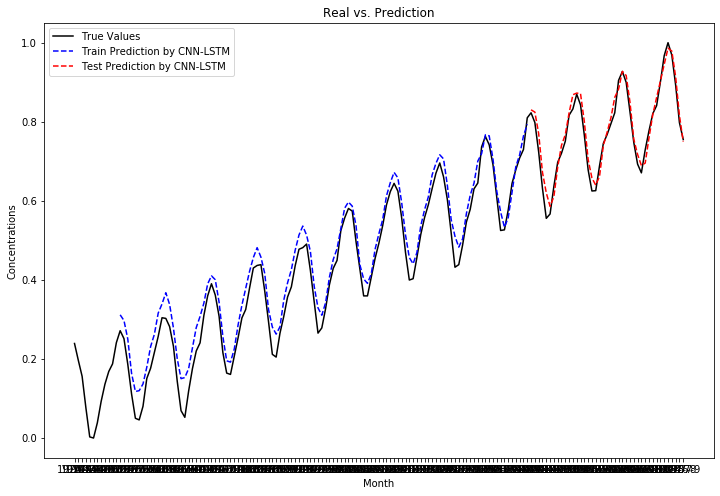

In [247]:
plt.figure(figsize=(12,8))
plt.plot(df.index, df.Concentrations, 'k')
plt.plot(trainprediction_clstm, '--b')
plt.plot(testprediction_clstm, '--r')
plt.title('Real vs. Prediction')
plt.ylabel('Concentrations')
plt.xlabel('Month')
plt.legend(['True Values', 'Train Prediction by CNN-LSTM', 'Test Prediction by CNN-LSTM'], loc='best')
plt.show()

In [248]:
Metrics['RMSE_CNN-LSTM'] = RMSE(Y_test_clstm, testprediction_clstm)
Metrics['MAPE_CNN-LSTM'] = MAPE(Y_test_clstm, testprediction_clstm)
Metrics['SMAPE_CNN-LSTM'] = SMAPE(Y_test_clstm, testprediction_clstm)
Metrics['MSLE_CNN-LSTM'] = MSLE(Y_test_clstm, testprediction_clstm)
Metrics

{'RMSE_SARIMA': 0.01423000301804426,
 'MAPE_SARIMA': 1.5865366875918112,
 'SMAPE_SARIMA': 1.5850406810996358,
 'MSLE_SARIMA': 6.433348881884668e-05,
 'RMSE_MLP': 0.023860435472015638,
 'MAPE_MLP': 15.789529849804262,
 'SMAPE_MLP': 624.6064294055852,
 'MSLE_MLP': 0.00018648175463270236,
 'RMSE_LSTM': 0.02233499336958177,
 'MAPE_LSTM': 16.443648692578037,
 'SMAPE_LSTM': 674.44300437793,
 'MSLE_LSTM': 0.00016366758312043311,
 'RMSE_SUL': 0.03341717551538441,
 'MAPE_SUL': 15.287985251891131,
 'SMAPE_SUL': 600.298397765347,
 'MSLE_SUL': 0.0003837868261487911,
 'RMSE_BL': 0.018727167063783023,
 'MAPE_BL': 15.61053999851306,
 'SMAPE_BL': 628.0273774037925,
 'MSLE_BL': 0.00011168522837371326,
 'RMSE_SBL': 0.05030619285406642,
 'MAPE_SBL': 14.203796650434985,
 'SMAPE_SBL': 597.835927799143,
 'MSLE_SBL': 0.0007449517807820243,
 'RMSE_CNN-LSTM': 0.024295749773294555,
 'MAPE_CNN-LSTM': 16.084739742170402,
 'SMAPE_CNN-LSTM': 637.280778499916,
 'MSLE_CNN-LSTM': 0.0001987554749603132}

# SimpleRNN

It can also be used for multivariate time series analysis.

The input shape is in this form: [timesteps, features].

The X input is 3-dimensional: [samples, timesteps, features]   

In [252]:
lag_rnn = 12
X_train_rnn, Y_train_rnn, X_test_rnn, Y_test_rnn = input_output_generator_LSTM(df['Concentrations'].tolist(),
                                                                               lag_rnn)

In [117]:
#tuning optimizer. This can give us a good starting point.
opt = ['Adam', 'Adagrad']
lr = [0.001, 0.1]
e = Tune_optimizer('SimpleRNN', X_train_rnn, Y_train_rnn, 128, validation_split, 50, 10, opt, lr)
optimizer = (min(e, key=e.get)).split(', ')[0]
learning_rate = float(((min(e, key=e.get)).split(', ')[1]).split('=')[1])
e

{'Adagrad, rate=0.001': 0.07730447142212479,
 'Adagrad, rate=0.1': 0.39939527048004997,
 'Adam, rate=0.001': 0.014627588153989226,
 'Adam, rate=0.1': 0.39939527048004997}

In [118]:
# tuning number of nodes in RNN layer
nodes = [[128, 64], [64, 64], [64, 32]]
e = Tune_nodes('SimpleRNN', X_train_rnn, Y_train_rnn, nodes, validation_split, 50, 10, optimizer, learning_rate)
e

{0: 0.07440391403657419, 1: 0.39939527048004997, 2: 0.01423214686413606}

In [121]:
nodes = [128, 64]

In [122]:
#tune batch size
batch = [10, 30]
e = Tune_batch('SimpleRNN', X_train_rnn, Y_train_rnn, nodes, validation_split, 50, batch, optimizer, learning_rate)
batch_size = int(min(e, key=e.get))

In [260]:
nodes = 500
batch_size = 50
learning_rate = 0.001
optimizer = 'Adam'
model_rnn = Model_Build('SimpleRNN', nodes, X_train_rnn, optimizer, learning_rate)
model_rnn.summary()

Model: "sequential_77"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_5 (SimpleRNN)     (None, 500)               251000    
_________________________________________________________________
dense_77 (Dense)             (None, 1)                 501       
Total params: 251,501
Trainable params: 251,501
Non-trainable params: 0
_________________________________________________________________


Train on 81 samples, validate on 27 samples
Epoch 1/100
81/81 [==============================] - 4s 44ms/step - loss: 0.9165 - accuracy: 0.0000e+00 - mse: 0.9165 - val_loss: 0.0095 - val_accuracy: 0.0000e+00 - val_mse: 0.0095
Epoch 2/100
81/81 [==============================] - 0s 892us/step - loss: 0.1380 - accuracy: 0.0000e+00 - mse: 0.1380 - val_loss: 0.3349 - val_accuracy: 0.0000e+00 - val_mse: 0.3349
Epoch 3/100
81/81 [==============================] - 0s 831us/step - loss: 0.0945 - accuracy: 0.0000e+00 - mse: 0.0945 - val_loss: 0.2027 - val_accuracy: 0.0000e+00 - val_mse: 0.2027
Epoch 4/100
81/81 [==============================] - 0s 834us/step - loss: 0.0313 - accuracy: 0.0000e+00 - mse: 0.0313 - val_loss: 0.0542 - val_accuracy: 0.0000e+00 - val_mse: 0.0542
Epoch 5/100
81/81 [==============================] - 0s 861us/step - loss: 0.0207 - accuracy: 0.0000e+00 - mse: 0.0207 - val_loss: 0.0154 - val_accuracy: 0.0000e+00 - val_mse: 0.0154
Epoch 6/100
81/81 [=======================

81/81 [==============================] - 0s 641us/step - loss: 3.1716e-04 - accuracy: 0.0000e+00 - mse: 3.1716e-04 - val_loss: 7.1414e-04 - val_accuracy: 0.0000e+00 - val_mse: 7.1414e-04
Epoch 86/100
81/81 [==============================] - 0s 656us/step - loss: 3.1633e-04 - accuracy: 0.0000e+00 - mse: 3.1633e-04 - val_loss: 7.1163e-04 - val_accuracy: 0.0000e+00 - val_mse: 7.1163e-04
Epoch 87/100
81/81 [==============================] - 0s 706us/step - loss: 3.1528e-04 - accuracy: 0.0000e+00 - mse: 3.1528e-04 - val_loss: 7.1116e-04 - val_accuracy: 0.0000e+00 - val_mse: 7.1116e-04
Epoch 88/100
81/81 [==============================] - 0s 711us/step - loss: 3.1438e-04 - accuracy: 0.0000e+00 - mse: 3.1438e-04 - val_loss: 7.0937e-04 - val_accuracy: 0.0000e+00 - val_mse: 7.0937e-04
Epoch 89/100
81/81 [==============================] - 0s 699us/step - loss: 3.1350e-04 - accuracy: 0.0000e+00 - mse: 3.1349e-04 - val_loss: 7.0795e-04 - val_accuracy: 0.0000e+00 - val_mse: 7.0795e-04
Epoch 90/100


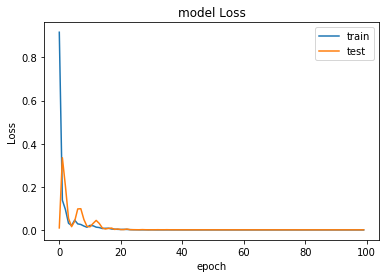

In [261]:
history_rnn = model_rnn.fit(X_train_rnn, Y_train_rnn, validation_split=validation_split, epochs=100,
                            batch_size=batch_size, verbose=1, shuffle=False)
plt.plot(history_rnn.history['loss'])
plt.plot(history_rnn.history['val_loss'])
plt.title('model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

Train on 81 samples, validate on 27 samples
Epoch 1/100
81/81 [==============================] - 7s 87ms/step - loss: 0.1175 - acc: 0.0000e+00 - mean_squared_error: 0.1175 - val_loss: 2.6264 - val_acc: 0.0000e+00 - val_mean_squared_error: 2.6264
Epoch 2/100
81/81 [==============================] - 0s 1ms/step - loss: 3.4939 - acc: 0.0000e+00 - mean_squared_error: 3.4939 - val_loss: 0.0346 - val_acc: 0.0000e+00 - val_mean_squared_error: 0.0346
Epoch 3/100
81/81 [==============================] - 0s 1ms/step - loss: 0.0339 - acc: 0.0000e+00 - mean_squared_error: 0.0339 - val_loss: 0.3297 - val_acc: 0.0000e+00 - val_mean_squared_error: 0.3297
Epoch 4/100
81/81 [==============================] - 0s 1ms/step - loss: 0.1028 - acc: 0.0000e+00 - mean_squared_error: 0.1028 - val_loss: 0.2791 - val_acc: 0.0000e+00 - val_mean_squared_error: 0.2791
Epoch 5/100
81/81 [==============================] - 0s 1ms/step - loss: 0.0808 - acc: 0.0000e+00 - mean_squared_error: 0.0808 - val_loss: 0.1619 - val

Epoch 42/100
81/81 [==============================] - 0s 1ms/step - loss: 5.5246e-04 - acc: 0.0000e+00 - mean_squared_error: 5.5246e-04 - val_loss: 9.6470e-04 - val_acc: 0.0000e+00 - val_mean_squared_error: 9.6470e-04
Epoch 43/100
81/81 [==============================] - 0s 1ms/step - loss: 9.5326e-04 - acc: 0.0000e+00 - mean_squared_error: 9.5326e-04 - val_loss: 9.6706e-04 - val_acc: 0.0000e+00 - val_mean_squared_error: 9.6706e-04
Epoch 44/100
81/81 [==============================] - 0s 1ms/step - loss: 6.7519e-04 - acc: 0.0000e+00 - mean_squared_error: 6.7519e-04 - val_loss: 8.9222e-04 - val_acc: 0.0000e+00 - val_mean_squared_error: 8.9222e-04
Epoch 45/100
81/81 [==============================] - 0s 1ms/step - loss: 4.7642e-04 - acc: 0.0000e+00 - mean_squared_error: 4.7642e-04 - val_loss: 0.0010 - val_acc: 0.0000e+00 - val_mean_squared_error: 0.0010
Epoch 46/100
81/81 [==============================] - 0s 1ms/step - loss: 8.2809e-04 - acc: 0.0000e+00 - mean_squared_error: 8.2809e-04 

81/81 [==============================] - 0s 1ms/step - loss: 3.6917e-04 - acc: 0.0000e+00 - mean_squared_error: 3.6917e-04 - val_loss: 7.3160e-04 - val_acc: 0.0000e+00 - val_mean_squared_error: 7.3160e-04
Epoch 81/100
81/81 [==============================] - 0s 1ms/step - loss: 3.5919e-04 - acc: 0.0000e+00 - mean_squared_error: 3.5919e-04 - val_loss: 7.1302e-04 - val_acc: 0.0000e+00 - val_mean_squared_error: 7.1302e-04
Epoch 82/100
81/81 [==============================] - 0s 1ms/step - loss: 3.5988e-04 - acc: 0.0000e+00 - mean_squared_error: 3.5988e-04 - val_loss: 7.0977e-04 - val_acc: 0.0000e+00 - val_mean_squared_error: 7.0977e-04
Epoch 83/100
81/81 [==============================] - 0s 1ms/step - loss: 3.5903e-04 - acc: 0.0000e+00 - mean_squared_error: 3.5903e-04 - val_loss: 7.3434e-04 - val_acc: 0.0000e+00 - val_mean_squared_error: 7.3434e-04
Epoch 84/100
81/81 [==============================] - 0s 1ms/step - loss: 3.5139e-04 - acc: 0.0000e+00 - mean_squared_error: 3.5139e-04 - val

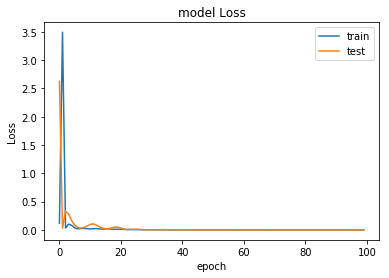

In [164]:
lag_rnn = 12
X_train_rnn, Y_train_rnn, X_test_rnn, Y_test_rnn = input_output_generator_LSTM(df['Concentrations'].tolist(),
                                                                               lag_rnn)
model_rnn = Model_Build('SimpleRNN', nodes, X_train_rnn, optimizer, learning_rate)
history_rnn = model_rnn.fit(X_train_rnn, Y_train_rnn, validation_split=validation_split, epochs=100,
                            batch_size=batch_size, verbose=1, shuffle=False)
plt.plot(history_rnn.history['loss'])
plt.plot(history_rnn.history['val_loss'])
plt.title('model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

saving/loading the model:

In [167]:
model_rnn.save('/home/ahmada59/py/CO2Concentrations_rnn.h5')
# to load the model:
# model_rnn = load_model('/home/ahmada59/py/CO2Concentrations_rnn.h5')

Forecast:

In [262]:
trainprediction_rnn = model_rnn.predict(X_train_rnn)
testprediction_rnn = model_rnn.predict(X_test_rnn)
trainprediction_rnn = pd.DataFrame(index=df.index[lag_rnn:len(df)-len(X_test_rnn)], data=trainprediction_rnn)
testprediction_rnn = pd.DataFrame(index=df.index[len(df)-len(X_test_rnn):], data=testprediction_rnn)

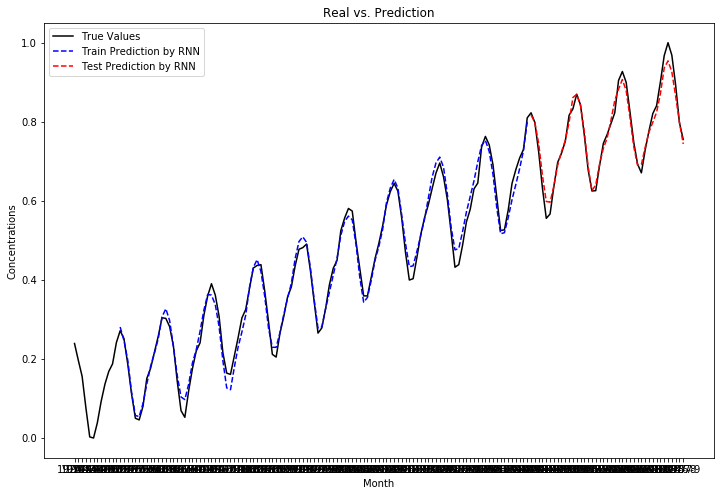

In [263]:
plt.figure(figsize=(12,8))
plt.plot(df.index, df.Concentrations, 'k')
plt.plot(trainprediction_rnn, '--b')
plt.plot(testprediction_rnn, '--r')
plt.title('Real vs. Prediction')
plt.ylabel('Concentrations')
plt.xlabel('Month')
plt.legend(['True Values', 'Train Prediction by RNN', 'Test Prediction by RNN'], loc='best')
plt.show()

In [264]:
Metrics['RMSE_RNN'] = RMSE(Y_test_rnn, testprediction_rnn)
Metrics['MAPE_RNN'] = MAPE(Y_test_rnn, testprediction_rnn)
Metrics['SMAPE_RNN'] = SMAPE(Y_test_rnn, testprediction_rnn)
Metrics['MSLE_RNN'] = MSLE(Y_test_rnn, testprediction_rnn)
Metrics

{'RMSE_SARIMA': 0.01423000301804426,
 'MAPE_SARIMA': 1.5865366875918112,
 'SMAPE_SARIMA': 1.5850406810996358,
 'MSLE_SARIMA': 6.433348881884668e-05,
 'RMSE_MLP': 0.023860435472015638,
 'MAPE_MLP': 15.789529849804262,
 'SMAPE_MLP': 624.6064294055852,
 'MSLE_MLP': 0.00018648175463270236,
 'RMSE_LSTM': 0.02233499336958177,
 'MAPE_LSTM': 16.443648692578037,
 'SMAPE_LSTM': 674.44300437793,
 'MSLE_LSTM': 0.00016366758312043311,
 'RMSE_SUL': 0.03341717551538441,
 'MAPE_SUL': 15.287985251891131,
 'SMAPE_SUL': 600.298397765347,
 'MSLE_SUL': 0.0003837868261487911,
 'RMSE_BL': 0.018727167063783023,
 'MAPE_BL': 15.61053999851306,
 'SMAPE_BL': 628.0273774037925,
 'MSLE_BL': 0.00011168522837371326,
 'RMSE_SBL': 0.05030619285406642,
 'MAPE_SBL': 14.203796650434985,
 'SMAPE_SBL': 597.835927799143,
 'MSLE_SBL': 0.0007449517807820243,
 'RMSE_CNN-LSTM': 0.024295749773294555,
 'MAPE_CNN-LSTM': 16.084739742170402,
 'SMAPE_CNN-LSTM': 637.280778499916,
 'MSLE_CNN-LSTM': 0.0001987554749603132,
 'RMSE_RNN': 0.

# GRU

In [346]:
lag_gru = 6
X_train_gru, Y_train_gru, X_test_gru, Y_test_gru = input_output_generator_LSTM(df['Concentrations'].tolist(),
                                                                               lag_gru)

In [39]:
#tuning optimizer. This can give us a good starting point.
opt = ['Adam', 'Adagrad']
lr = [0.001, 0.1]
e = Tune_optimizer('GRU', X_train_gru, Y_train_gru, [128, 64], validation_split, 50, 10, opt, lr)
optimizer = (min(e, key=e.get)).split(', ')[0]
learning_rate = float(((min(e, key=e.get)).split(', ')[1]).split('=')[1])
e

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


{'Adam, rate=0.001': 0.006203714620184015,
 'Adam, rate=0.1': 0.15005501828811788,
 'Adagrad, rate=0.001': 0.04494460768721722,
 'Adagrad, rate=0.1': 0.004091221356281528}

In [40]:
# tuning number of nodes in RNN layer
nodes = [[128, 64], [64, 64], [64, 32]]
e = Tune_nodes('GRU', X_train_gru, Y_train_gru, nodes, validation_split, 50, 10, optimizer, learning_rate)
e

{0: 0.0031210720642573303, 1: 0.002071766294883909, 2: 0.011759170572514887}

In [41]:
nodes = [64, 64]

In [42]:
#tune batch size
batch = [10, 30]
e = Tune_batch('GRU', X_train_gru, Y_train_gru, nodes, validation_split, 50, batch, optimizer, learning_rate)
batch_size = int(min(e, key=e.get))

Building the model:

In [354]:
nodes = 300
batch_size = 10
learning_rate = 0.001
optimizer = 'Adam'
model_gru = Model_Build('GRU', nodes, X_train_gru, optimizer, learning_rate)
model_gru.summary()

Model: "sequential_109"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_50 (GRU)                 (None, 300)               271800    
_________________________________________________________________
dense_95 (Dense)             (None, 1)                 301       
Total params: 272,101
Trainable params: 272,101
Non-trainable params: 0
_________________________________________________________________


Train on 85 samples, validate on 29 samples
Epoch 1/120
85/85 [==============================] - 6s 67ms/step - loss: 0.0150 - accuracy: 0.0000e+00 - mse: 0.0150 - val_loss: 0.0086 - val_accuracy: 0.0000e+00 - val_mse: 0.0086
Epoch 2/120
85/85 [==============================] - 0s 2ms/step - loss: 0.0615 - accuracy: 0.0000e+00 - mse: 0.0615 - val_loss: 0.1407 - val_accuracy: 0.0000e+00 - val_mse: 0.1407
Epoch 3/120
85/85 [==============================] - 0s 2ms/step - loss: 0.0287 - accuracy: 0.0000e+00 - mse: 0.0287 - val_loss: 0.1174 - val_accuracy: 0.0000e+00 - val_mse: 0.1174
Epoch 4/120
85/85 [==============================] - 0s 2ms/step - loss: 0.0160 - accuracy: 0.0000e+00 - mse: 0.0160 - val_loss: 0.0556 - val_accuracy: 0.0000e+00 - val_mse: 0.0556
Epoch 5/120
85/85 [==============================] - 0s 2ms/step - loss: 0.0197 - accuracy: 0.0000e+00 - mse: 0.0197 - val_loss: 0.0462 - val_accuracy: 0.0000e+00 - val_mse: 0.0462
Epoch 6/120
85/85 [==============================]

Epoch 46/120
85/85 [==============================] - 0s 2ms/step - loss: 0.0017 - accuracy: 0.0000e+00 - mse: 0.0017 - val_loss: 0.0023 - val_accuracy: 0.0000e+00 - val_mse: 0.0023
Epoch 47/120
85/85 [==============================] - 0s 2ms/step - loss: 0.0016 - accuracy: 0.0000e+00 - mse: 0.0016 - val_loss: 0.0023 - val_accuracy: 0.0000e+00 - val_mse: 0.0023
Epoch 48/120
85/85 [==============================] - 0s 2ms/step - loss: 0.0015 - accuracy: 0.0000e+00 - mse: 0.0015 - val_loss: 0.0023 - val_accuracy: 0.0000e+00 - val_mse: 0.0023
Epoch 49/120
85/85 [==============================] - 0s 2ms/step - loss: 0.0015 - accuracy: 0.0000e+00 - mse: 0.0015 - val_loss: 0.0023 - val_accuracy: 0.0000e+00 - val_mse: 0.0023
Epoch 50/120
85/85 [==============================] - 0s 2ms/step - loss: 0.0015 - accuracy: 0.0000e+00 - mse: 0.0015 - val_loss: 0.0022 - val_accuracy: 0.0000e+00 - val_mse: 0.0022
Epoch 51/120
85/85 [==============================] - 0s 2ms/step - loss: 0.0015 - accurac

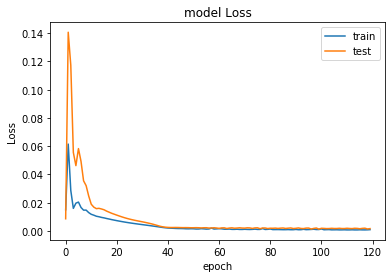

In [355]:
history_gru = model_gru.fit(X_train_gru, Y_train_gru, validation_split=validation_split,
                            epochs=120, batch_size=batch_size, verbose=1, shuffle=False)
plt.plot(history_gru.history['loss'])
plt.plot(history_gru.history['val_loss'])
plt.title('model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

saving/loading the model:

In [122]:
model_gru.save('/home/ahmada59/py/CO2Concentrations_gru.h5')
# to load the model:
# model_gru = load_model('/home/ahmada59/py/CO2Concentrations_gru.h5')

Forecasting:

In [356]:
trainprediction_gru = model_gru.predict(X_train_gru)
testprediction_gru = model_gru.predict(X_test_gru)
trainprediction_gru = pd.DataFrame(index=df.index[lag_gru:len(df)-len(X_test_gru)], data=trainprediction_gru)
testprediction_gru = pd.DataFrame(index=df.index[len(df)-len(X_test_gru):], data=testprediction_gru)

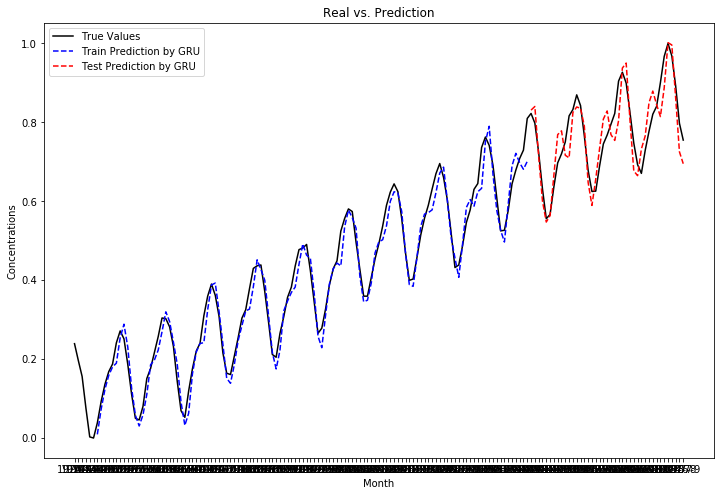

In [357]:
plt.figure(figsize=(12,8))
plt.plot(df.index, df.Concentrations, 'k')
plt.plot(trainprediction_gru, '--b')
plt.plot(testprediction_gru, '--r')
plt.title('Real vs. Prediction')
plt.ylabel('Concentrations')
plt.xlabel('Month')
plt.legend(['True Values', 'Train Prediction by GRU', 'Test Prediction by GRU'], loc='best')
plt.show()

In [358]:
Metrics['RMSE_GRU'] = RMSE(Y_test_gru, testprediction_gru)
Metrics['MAPE_GRU'] = MAPE(Y_test_gru, testprediction_gru)
Metrics['SMAPE_GRU'] = SMAPE(Y_test_gru, testprediction_gru)
Metrics['MSLE_GRU'] = MSLE(Y_test_gru, testprediction_gru)
Metrics

{'RMSE_SARIMA': 0.01423000301804426,
 'MAPE_SARIMA': 1.5865366875918112,
 'SMAPE_SARIMA': 1.5850406810996358,
 'MSLE_SARIMA': 6.433348881884668e-05,
 'RMSE_MLP': 0.023860435472015638,
 'MAPE_MLP': 15.789529849804262,
 'SMAPE_MLP': 624.6064294055852,
 'MSLE_MLP': 0.00018648175463270236,
 'RMSE_LSTM': 0.02233499336958177,
 'MAPE_LSTM': 16.443648692578037,
 'SMAPE_LSTM': 674.44300437793,
 'MSLE_LSTM': 0.00016366758312043311,
 'RMSE_SUL': 0.03341717551538441,
 'MAPE_SUL': 15.287985251891131,
 'SMAPE_SUL': 600.298397765347,
 'MSLE_SUL': 0.0003837868261487911,
 'RMSE_BL': 0.018727167063783023,
 'MAPE_BL': 15.61053999851306,
 'SMAPE_BL': 628.0273774037925,
 'MSLE_BL': 0.00011168522837371326,
 'RMSE_SBL': 0.05030619285406642,
 'MAPE_SBL': 14.203796650434985,
 'SMAPE_SBL': 597.835927799143,
 'MSLE_SBL': 0.0007449517807820243,
 'RMSE_CNN-LSTM': 0.024295749773294555,
 'MAPE_CNN-LSTM': 16.084739742170402,
 'SMAPE_CNN-LSTM': 637.280778499916,
 'MSLE_CNN-LSTM': 0.0001987554749603132,
 'RMSE_RNN': 0.

# DC-CNN: Dilated Causal Convolutional Neural Network:

Dilated Causal Convolutional Neural Networks:

Input(shape = (n_sample, timesteps, n_features)) or (batch, steps, channels)

In [360]:
def Model_Build_DCCNN(n_filters, filter_width, dilation_rates, input, nodes, dropout, optimizer, learning_rate):
    # nodes is a list containing number of nodes in each dense layer. 
    # x is the Input to the network generated by Input() function in keras. it is a placeholder for input.
    # n_filters, filter_width and dilation_rates are used in Conv1D layers.
    x = input
    for dilation_rate in dilation_rates:
        x = Conv1D(filters = n_filters, kernel_size = filter_width, padding = 'causal',
                  dilation_rate = dilation_rate)(x)
    x = Flatten()(x)
    for i in nodes:
        x = Dense(i, activation='relu', kernel_initializer='random_uniform', bias_initializer='zeros')(x)
        if i != 1:
            x = Dropout(dropout)(x)
    model = Model(inputs = input, outputs = x)
    if optimizer == 'SGD':
        sgd = optimizers.SGD(lr=learning_rate, momentum=0)
        model.compile(loss='mean_squared_error', optimizer=sgd, metrics=['accuracy', 'mse'])
    if optimizer == 'RMSprop':
        rmsprop = optimizers.RMSprop(lr=learning_rate, rho=0.9)
        model.compile(loss='mean_squared_error', optimizer=rmsprop, metrics=['accuracy', 'mse'])
    if optimizer == 'Adagrad':
        adagrad = optimizers.Adagrad(lr=learning_rate)
        model.compile(loss='mean_squared_error', optimizer=adagrad, metrics=['accuracy', 'mse'])
    if optimizer == 'Adadelta':
        adadelta = optimizers.Adadelta(lr=learning_rate, rho=0.95)
        model.compile(loss='mean_squared_error', optimizer=adadelta, metrics=['accuracy', 'mse'])
    if optimizer == 'Adam':
        adam = optimizers.Adam(learning_rate)
        model.compile(loss='mean_squared_error', optimizer=adam, metrics=['accuracy', 'mse'])
    return model

def Tune_optimizer_DCCNN(X_train, Y_train, n_filters, filter_width, dilation_rates, input, nodes, dropout, val_split, epochs, batch_size, optimizer, learning_rate):
    #this function tunes the optimizer and the learning rate.
    e = {}
    for i in range(len(optimizer)):
        for j in range(len(learning_rate)):
            model = Model_Build_DCCNN(n_filters, filter_width, dilation_rates, input, nodes, dropout, optimizer[i], learning_rate[j])
            history = model.fit(X_train, Y_train, validation_split=val_split, epochs=epochs, batch_size=batch_size, verbose=0, shuffle=False)
            e[optimizer[i]+', rate='+str(learning_rate[j])] = history.history['val_loss'][-1]
    return e

def Tune_batch_DCCNN(X_train, Y_train, n_filters, filter_width, dilation_rates, input, nodes, dropout, val_split, epochs, batch_size, optimizer, learning_rate):
    #this function tunes the batch size.
    e = {}
    for i in batch_size:
        model = Model_Build_DCCNN(n_filters, filter_width, dilation_rates, input, nodes, dropout, optimizer, learning_rate)
        history = model.fit(X_train, Y_train, validation_split=val_split, epochs=epochs, batch_size=i, verbose=0, shuffle=False)
        e[i] = history.history['val_loss'][-1]
    return e

In [362]:
lag_dccnn = 12
X_train_dccnn, Y_train_dccnn, X_test_dccnn, Y_test_dccnn = input_output_generator_LSTM(df['Concentrations'].tolist(),
                                                                                       lag_dccnn)
n_filters = 32
filter_width = 2
dilation_rates = [2**i for i in range(7)]
dropout = 0.1
input = Input(shape=(X_train_dccnn.shape[1:]))
nodes = [128, 64, 32, 1]

In [132]:
#tuning optimizer. This can give us a good starting point.
opt = ['Adam', 'Adagrad']
lr = [0.001, 0.01]
e = Tune_optimizer_DCCNN(X_train_dccnn, Y_train_dccnn, n_filters, filter_width, dilation_rates, input, nodes,
                         dropout, validation_split, 50, 10, opt, lr)
optimizer = (min(e, key=e.get)).split(', ')[0]
learning_rate = float(((min(e, key=e.get)).split(', ')[1]).split('=')[1])
e

{'Adam, rate=0.001': 0.0013856445784094157,
 'Adam, rate=0.01': 0.07651403463549084,
 'Adagrad, rate=0.001': 0.011277521477529296,
 'Adagrad, rate=0.01': 0.0029255162398503336}

In [133]:
#tune batch size
batch = [10, 30]
e = Tune_batch_DCCNN(X_train_dccnn, Y_train_dccnn, n_filters, filter_width, dilation_rates, input, nodes,
                     dropout, validation_split, 50, batch, optimizer, learning_rate)
batch_size = int(min(e, key=e.get))

Building the model:

In [433]:
n_filters = 32
filter_width = 2
dilation_rates = [2**i for i in range(8)]
dropout = 0
nodes = [128, 64, 32, 1]
optimizer = 'Adam'
learning_rate = 0.0005
batch_size = 10
model_dccnn = Model_Build_DCCNN(n_filters, filter_width, dilation_rates, input, nodes, dropout,
                                optimizer, learning_rate)
model_dccnn.summary()

Model: "model_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 12, 1)             0         
_________________________________________________________________
conv1d_169 (Conv1D)          (None, 12, 32)            96        
_________________________________________________________________
conv1d_170 (Conv1D)          (None, 12, 32)            2080      
_________________________________________________________________
conv1d_171 (Conv1D)          (None, 12, 32)            2080      
_________________________________________________________________
conv1d_172 (Conv1D)          (None, 12, 32)            2080      
_________________________________________________________________
conv1d_173 (Conv1D)          (None, 12, 32)            2080      
_________________________________________________________________
conv1d_174 (Conv1D)          (None, 12, 32)            208

Train on 81 samples, validate on 27 samples
Epoch 1/100
81/81 [==============================] - 7s 90ms/step - loss: 0.1370 - accuracy: 0.0000e+00 - mse: 0.1370 - val_loss: 0.3849 - val_accuracy: 0.0000e+00 - val_mse: 0.3849
Epoch 2/100
81/81 [==============================] - 0s 2ms/step - loss: 0.1225 - accuracy: 0.0000e+00 - mse: 0.1225 - val_loss: 0.3104 - val_accuracy: 0.0000e+00 - val_mse: 0.3104
Epoch 3/100
81/81 [==============================] - 0s 1ms/step - loss: 0.0522 - accuracy: 0.0000e+00 - mse: 0.0522 - val_loss: 0.0131 - val_accuracy: 0.0000e+00 - val_mse: 0.0131
Epoch 4/100
81/81 [==============================] - 0s 1ms/step - loss: 0.0263 - accuracy: 0.0000e+00 - mse: 0.0263 - val_loss: 0.0219 - val_accuracy: 0.0000e+00 - val_mse: 0.0219
Epoch 5/100
81/81 [==============================] - 0s 2ms/step - loss: 0.0245 - accuracy: 0.0000e+00 - mse: 0.0245 - val_loss: 0.0604 - val_accuracy: 0.0000e+00 - val_mse: 0.0604
Epoch 6/100
81/81 [==============================]

Epoch 88/100
81/81 [==============================] - 0s 1ms/step - loss: 5.1036e-04 - accuracy: 0.0000e+00 - mse: 5.1036e-04 - val_loss: 7.8483e-04 - val_accuracy: 0.0000e+00 - val_mse: 7.8483e-04
Epoch 89/100
81/81 [==============================] - 0s 1ms/step - loss: 8.5372e-04 - accuracy: 0.0000e+00 - mse: 8.5372e-04 - val_loss: 9.3911e-04 - val_accuracy: 0.0000e+00 - val_mse: 9.3911e-04
Epoch 90/100
81/81 [==============================] - 0s 1ms/step - loss: 8.7361e-04 - accuracy: 0.0000e+00 - mse: 8.7361e-04 - val_loss: 0.0018 - val_accuracy: 0.0000e+00 - val_mse: 0.0018
Epoch 91/100
81/81 [==============================] - 0s 1ms/step - loss: 6.9732e-04 - accuracy: 0.0000e+00 - mse: 6.9732e-04 - val_loss: 0.0019 - val_accuracy: 0.0000e+00 - val_mse: 0.0019
Epoch 92/100
81/81 [==============================] - 0s 1ms/step - loss: 6.5207e-04 - accuracy: 0.0000e+00 - mse: 6.5207e-04 - val_loss: 0.0011 - val_accuracy: 0.0000e+00 - val_mse: 0.0011
Epoch 93/100
81/81 [==============

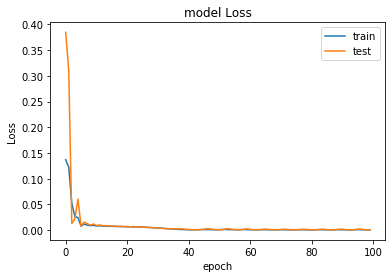

In [434]:
history_dccnn = model_dccnn.fit(X_train_dccnn, Y_train_dccnn, validation_split=validation_split,
                                epochs=100, verbose=1, batch_size=batch_size, shuffle=False)
plt.plot(history_dccnn.history['loss'])
plt.plot(history_dccnn.history['val_loss'])
plt.title('model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

Saving/loading the model:

In [439]:
model_dccnn.save('/home/ahmada59/py/CO2Concentrations_DC-CNN.h5')
# to load the model:
# model_dccnn = load_model('/home/ahmada59/py/CO2Concentrations_DC-CNN.h5')

Forecasting:

In [435]:
trainprediction_dccnn = model_dccnn.predict(X_train_dccnn)
testprediction_dccnn = model_dccnn.predict(X_test_dccnn)
trainprediction_dccnn = pd.DataFrame(index=df.index[lag_dccnn:len(df)-len(X_test_dccnn)], data=trainprediction_dccnn)
testprediction_dccnn = pd.DataFrame(index=df.index[len(df)-len(X_test_dccnn):], data=testprediction_dccnn)

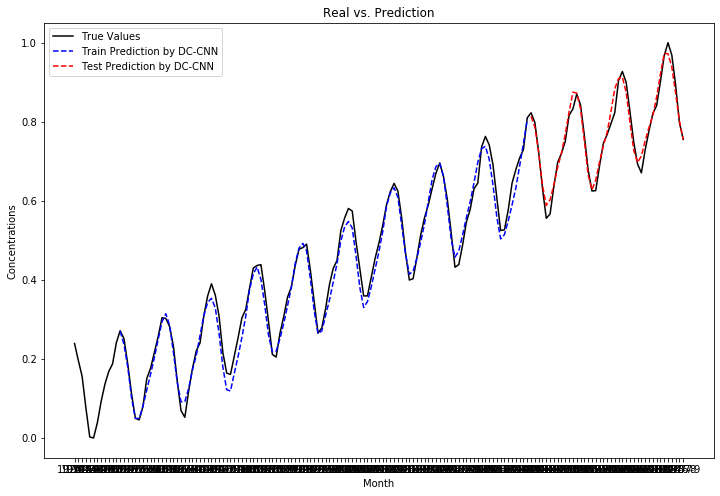

In [436]:
plt.figure(figsize=(12,8))
plt.plot(df.index, df.Concentrations, 'k')
plt.plot(trainprediction_dccnn, '--b')
plt.plot(testprediction_dccnn, '--r')
plt.title('Real vs. Prediction')
plt.ylabel('Concentrations')
plt.xlabel('Month')
plt.legend(['True Values', 'Train Prediction by DC-CNN', 'Test Prediction by DC-CNN'], loc='best')
plt.show()

In [437]:
Metrics['RMSE_DCCNN'] = RMSE(Y_test_dccnn, testprediction_dccnn)
Metrics['MAPE_DCCNN'] = MAPE(Y_test_dccnn, testprediction_dccnn)
Metrics['SMAPE_DCCNN'] = SMAPE(Y_test_dccnn, testprediction_dccnn)
Metrics['MSLE_DCCNN'] = MSLE(Y_test_dccnn, testprediction_dccnn)
Metrics

{'RMSE_SARIMA': 0.01423000301804426,
 'MAPE_SARIMA': 1.5865366875918112,
 'SMAPE_SARIMA': 1.5850406810996358,
 'MSLE_SARIMA': 6.433348881884668e-05,
 'RMSE_MLP': 0.023860435472015638,
 'MAPE_MLP': 15.789529849804262,
 'SMAPE_MLP': 624.6064294055852,
 'MSLE_MLP': 0.00018648175463270236,
 'RMSE_LSTM': 0.02233499336958177,
 'MAPE_LSTM': 16.443648692578037,
 'SMAPE_LSTM': 674.44300437793,
 'MSLE_LSTM': 0.00016366758312043311,
 'RMSE_SUL': 0.03341717551538441,
 'MAPE_SUL': 15.287985251891131,
 'SMAPE_SUL': 600.298397765347,
 'MSLE_SUL': 0.0003837868261487911,
 'RMSE_BL': 0.018727167063783023,
 'MAPE_BL': 15.61053999851306,
 'SMAPE_BL': 628.0273774037925,
 'MSLE_BL': 0.00011168522837371326,
 'RMSE_SBL': 0.05030619285406642,
 'MAPE_SBL': 14.203796650434985,
 'SMAPE_SBL': 597.835927799143,
 'MSLE_SBL': 0.0007449517807820243,
 'RMSE_CNN-LSTM': 0.024295749773294555,
 'MAPE_CNN-LSTM': 16.084739742170402,
 'SMAPE_CNN-LSTM': 637.280778499916,
 'MSLE_CNN-LSTM': 0.0001987554749603132,
 'RMSE_RNN': 0.

# SeriesNet:

Code is inspired from: https://github.com/kristpapadopoulos/seriesnet/blob/master

Source: SeriesNet: A Dilated Causal Convolutional Neural Network for Forecasting.

The network structure can be found there.

The network accepts a 3-D input as [number of samples, number of time steps, number of features] and outputs a 3D data. We will take the last time step in each sample az output (becuase in each sample the training is (t-3,t-2,t-1,t) and the test is (t-2,t-1,t,t+1) for instance). Hence we need the last time step in each sample of test data. 

In [228]:
def DCCNN_Block(n_filters, filter_width, dilation_rate, l2reg,input):
    residual = input
    layer_1 = Conv1D(filters=n_filters, kernel_size=filter_width, dilation_rate=dilation_rate, 
                    activation='linear', padding='causal', use_bias=False, 
                    kernel_initializer=TruncatedNormal(mean=0.0, stddev=0.05, seed=10), 
                    kernel_regularizer=l2(l2reg))(input)    
    layer_1 = Activation('selu')(layer_1)
    skip = Conv1D(1,1, activation='linear', use_bias=False, 
                  kernel_initializer=TruncatedNormal(mean=0.0, stddev=0.05, seed=10),
                  kernel_regularizer=l2(l2reg))(layer_1)
    layer_2 = Conv1D(1,1, activation='linear', use_bias=False, 
                     kernel_initializer=TruncatedNormal(mean=0.0, stddev=0.05, seed=10),
                     kernel_regularizer=l2(l2reg))(layer_1)  
    To_Next_Layer = Add()([residual, layer_2])
    return To_Next_Layer, skip

def Model_Build_SN(length):
    # A function to build the seriesnet network!
    input = Input(shape=(length,1))
    n_filters = 32
    filter_width = 2
    dilation_rates = [2**i for i in range(7)] #for 7 layers.
    l2reg = 0.01
    l1a, l1b = DCCNN_Block(n_filters,filter_width,dilation_rates[0],l2reg,input)  
    l2a, l2b = DCCNN_Block(n_filters,filter_width,dilation_rates[1],l2reg,l1a) 
    l3a, l3b = DCCNN_Block(n_filters,filter_width,dilation_rates[2],l2reg,l2a)
    l4a, l4b = DCCNN_Block(n_filters,filter_width,dilation_rates[3],l2reg,l3a)
    l5a, l5b = DCCNN_Block(n_filters,filter_width,dilation_rates[4],l2reg,l4a)
    l6a, l6b = DCCNN_Block(n_filters,filter_width,dilation_rates[5],l2reg,l5a)
    l6b = Dropout(0.8)(l6b)
    l7a, l7b = DCCNN_Block(n_filters,filter_width,dilation_rates[6],l2reg,l6a)
    l7b = Dropout(0.8)(l7b) 
    l8 =   Add()([l1b, l2b, l3b, l4b, l5b, l6b, l7b])
    l9 =   Activation('relu')(l8)
    output =  Conv1D(1,1, activation='linear', use_bias=False, 
           kernel_initializer=TruncatedNormal(mean=0.0, stddev=0.05, seed=10),
           kernel_regularizer=l2(0.001))(l9)
    model = Model(input=input, output=output)
    adam = optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, decay=0.0, amsgrad=False)
    model.compile(loss='mean_squared_error', optimizer=adam, metrics=['accuracy', 'mse'])
    return model

In [229]:
def input_output_generator_SN(z,n):
    #generating input output sets for SeriesNet.
    x_train = []
    y_train = []
    x_test = []
    y_test= []
    z_test = z[math.floor(trainfrac*len(z)):]
    z_train = z[:math.floor(trainfrac*len(z))]
    for i in range(len(z_train)-n):
        x_train.append(z[i:i+n])
        y_train.append(z[i+1:i+n+1])
    for i in range(len(z_test)):
        x_test.append(z[len(z_train)-n+i:len(z_train)+i])
        y_test.append(z[len(z_train)-n+i+1:len(z_train)+i+1])
    x_train = np.array(x_train)
    y_train = np.array(y_train)
    x_test = np.array(x_test)
    y_test = np.array(y_test)
    x_train_lstm = np.reshape(x_train,(x_train.shape[0], x_train.shape[1],1))
    y_train_lstm = np.reshape(y_train,(y_train.shape[0], y_train.shape[1],1))
    x_test_lstm = np.reshape(x_test,(x_test.shape[0], x_test.shape[1],1))
    y_test_lstm = np.reshape(y_test,(y_test.shape[0], y_test.shape[1],1))
    return x_train_lstm, y_train_lstm, x_test_lstm, y_test_lstm

In [230]:
lag_sn = 12
X_train_sn, Y_train_sn, X_test_sn, Y_test_sn = input_output_generator_SN(df['Concentrations'].tolist(), lag_sn)
model_sn = Model_Build_SN(X_train_sn.shape[1])
model_sn.summary()

Model: "model_36"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 12, 1)        0                                            
__________________________________________________________________________________________________
conv1d_277 (Conv1D)             (None, 12, 32)       64          input_9[0][0]                    
__________________________________________________________________________________________________
activation_49 (Activation)      (None, 12, 32)       0           conv1d_277[0][0]                 
__________________________________________________________________________________________________
conv1d_279 (Conv1D)             (None, 12, 1)        32          activation_49[0][0]              
___________________________________________________________________________________________

/home/avesta/anaconda3/envs/py35/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


Train on 81 samples, validate on 27 samples
Epoch 1/200
81/81 [==============================] - 9s 116ms/step - loss: 0.1398 - accuracy: 0.0051 - mse: 0.1249 - val_loss: 0.3755 - val_accuracy: 0.0000e+00 - val_mse: 0.3607
Epoch 2/200
81/81 [==============================] - 0s 712us/step - loss: 0.1396 - accuracy: 0.0051 - mse: 0.1249 - val_loss: 0.3752 - val_accuracy: 0.0000e+00 - val_mse: 0.3606
Epoch 3/200
81/81 [==============================] - 0s 614us/step - loss: 0.1394 - accuracy: 0.0051 - mse: 0.1248 - val_loss: 0.3749 - val_accuracy: 0.0000e+00 - val_mse: 0.3605
Epoch 4/200
81/81 [==============================] - 0s 597us/step - loss: 0.1392 - accuracy: 0.0051 - mse: 0.1248 - val_loss: 0.3746 - val_accuracy: 0.0000e+00 - val_mse: 0.3604
Epoch 5/200
81/81 [==============================] - 0s 716us/step - loss: 0.1390 - accuracy: 0.0051 - mse: 0.1248 - val_loss: 0.3743 - val_accuracy: 0.0000e+00 - val_mse: 0.3602
Epoch 6/200
81/81 [==============================] - 0s 635us

81/81 [==============================] - 0s 531us/step - loss: 0.1290 - accuracy: 0.0051 - mse: 0.1239 - val_loss: 0.3628 - val_accuracy: 0.0000e+00 - val_mse: 0.3577
Epoch 92/200
81/81 [==============================] - 0s 617us/step - loss: 0.1290 - accuracy: 0.0051 - mse: 0.1239 - val_loss: 0.3627 - val_accuracy: 0.0000e+00 - val_mse: 0.3577
Epoch 93/200
81/81 [==============================] - 0s 546us/step - loss: 0.1289 - accuracy: 0.0051 - mse: 0.1239 - val_loss: 0.3626 - val_accuracy: 0.0000e+00 - val_mse: 0.3577
Epoch 94/200
81/81 [==============================] - 0s 580us/step - loss: 0.1288 - accuracy: 0.0051 - mse: 0.1239 - val_loss: 0.3626 - val_accuracy: 0.0000e+00 - val_mse: 0.3577
Epoch 95/200
81/81 [==============================] - 0s 546us/step - loss: 0.1288 - accuracy: 0.0051 - mse: 0.1239 - val_loss: 0.3625 - val_accuracy: 0.0000e+00 - val_mse: 0.3577
Epoch 96/200
81/81 [==============================] - 0s 530us/step - loss: 0.1287 - accuracy: 0.0051 - mse: 0.12

81/81 [==============================] - 0s 608us/step - loss: 0.1255 - accuracy: 0.0051 - mse: 0.1238 - val_loss: 0.3591 - val_accuracy: 0.0000e+00 - val_mse: 0.3574
Epoch 182/200
81/81 [==============================] - 0s 604us/step - loss: 0.1255 - accuracy: 0.0051 - mse: 0.1238 - val_loss: 0.3591 - val_accuracy: 0.0000e+00 - val_mse: 0.3574
Epoch 183/200
81/81 [==============================] - 0s 541us/step - loss: 0.1255 - accuracy: 0.0051 - mse: 0.1238 - val_loss: 0.3590 - val_accuracy: 0.0000e+00 - val_mse: 0.3574
Epoch 184/200
81/81 [==============================] - 0s 529us/step - loss: 0.1254 - accuracy: 0.0051 - mse: 0.1238 - val_loss: 0.3590 - val_accuracy: 0.0000e+00 - val_mse: 0.3574
Epoch 185/200
81/81 [==============================] - 0s 575us/step - loss: 0.1254 - accuracy: 0.0051 - mse: 0.1238 - val_loss: 0.3590 - val_accuracy: 0.0000e+00 - val_mse: 0.3574
Epoch 186/200
81/81 [==============================] - 0s 535us/step - loss: 0.1254 - accuracy: 0.0051 - mse:

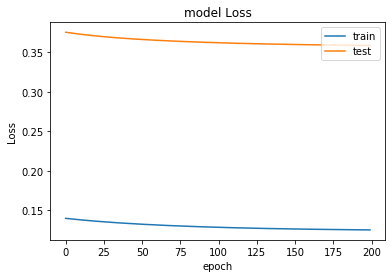

In [231]:
history_sn = model_sn.fit(X_train_sn, Y_train_sn, validation_split=validation_split, epochs=200,
                          verbose=1, batch_size=30, shuffle=False)
plt.plot(history_sn.history['loss'])
plt.plot(history_sn.history['val_loss'])
plt.title('model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

Saving/loading the model:

In [ ]:
model_sn.save('/home/ahmada59/py/CO2Concentrations_SN.h5')
# to load the model:
# model_sn = load_model('/home/ahmada59/py/CO2Concentrations_SN.h5')

Forecasting:

In [158]:
trainprediction_sn = model_sn.predict(X_train_sn)
testprediction_sn = model_sn.predict(X_test_sn)
trainprediction_sn = pd.DataFrame(index=df.index[lag_sn:len(df)-X_test_sn.shape[0]], data=trainprediction_sn[:,-1,:])
testprediction_sn = pd.DataFrame(index=df.index[len(df)-X_test_sn.shape[0]:], data=testprediction_sn[:,-1,:])

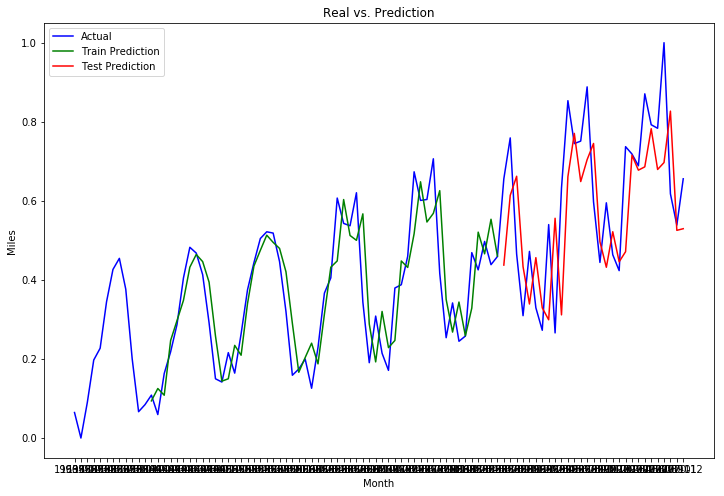

In [159]:
plt.figure(figsize=(12,8))
plt.plot(df.index, df.miles, 'b')
plt.plot(trainprediction_sn, 'g')
plt.plot(testprediction_sn, 'r')
plt.title('Real vs. Prediction')
plt.ylabel('Miles')
plt.xlabel('Month')
plt.legend(['Actual', 'Train Prediction', 'Test Prediction'], loc='upper left')
plt.show()

In [ ]:
Metrics['RMSE_SN'] = RMSE(Y_test_sn, testprediction_sn)
Metrics['MAPE_SN'] = MAPE(Y_test_sn, testprediction_sn)
Metrics['SMAPE_SN'] = SMAPE(Y_test_sn, testprediction_sn)
Metrics

# Series-Net Modified:

Here I have modified the series net network, as it accepts a 3D data same as before. But the output is just one
point. The output is the one-step ahead future timestep. I have added a Flatten layer and a Dense layer to get 
this output. The input shape is [number of samples, number of timesteps, number of features] and the output is 
[number of sample, future step].

In [508]:
def DCCNN_Block1(n_filters, filter_width, dilation_rate, l2reg,input):
    residual = input
    layer_1 = Conv1D(filters=n_filters, kernel_size=filter_width, dilation_rate=dilation_rate, 
                    activation='linear', padding='causal', use_bias=False, 
                    kernel_initializer=TruncatedNormal(mean=0.0, stddev=0.05, seed=10), 
                    kernel_regularizer=l2(l2reg))(input)    
    layer_1 = Activation('selu')(layer_1)
    skip = Conv1D(1,1, activation='linear', use_bias=False, 
                  kernel_initializer=TruncatedNormal(mean=0.0, stddev=0.05, seed=10),
                  kernel_regularizer=l2(l2reg))(layer_1)
    layer_2 = Conv1D(1,1, activation='linear', use_bias=False, 
                     kernel_initializer=TruncatedNormal(mean=0.0, stddev=0.05, seed=10),
                     kernel_regularizer=l2(l2reg))(layer_1)  
    To_Next_Layer = Add()([residual, layer_2])
    return To_Next_Layer, skip

def Model_Build_SN1(length, n_filters, filter_width, dilation_rates,l2reg):
    # A function to build the seriesnet network!
    # length is the input size of the training data. It is number of time steps used in the training data.
    input = Input(batch_shape=(None,length,1))
    l1a, l1b = DCCNN_Block1(n_filters,filter_width,dilation_rates[0],l2reg,input)  
    l2a, l2b = DCCNN_Block1(n_filters,filter_width,dilation_rates[1],l2reg,l1a) 
    l3a, l3b = DCCNN_Block1(n_filters,filter_width,dilation_rates[2],l2reg,l2a)
    l4a, l4b = DCCNN_Block1(n_filters,filter_width,dilation_rates[3],l2reg,l3a)
    l5a, l5b = DCCNN_Block1(n_filters,filter_width,dilation_rates[4],l2reg,l4a)
    l6a, l6b = DCCNN_Block1(n_filters,filter_width,dilation_rates[5],l2reg,l5a)
    l6b = Dropout(0.6)(l6b)
    l7a, l7b = DCCNN_Block1(n_filters,filter_width,dilation_rates[6],l2reg,l6a)
    l7b = Dropout(0.6)(l7b) 
    l8 =   Add()([l1b, l2b, l3b, l4b, l5b, l6b, l7b])
    l9 =   Activation('relu')(l8)
    l10 =  Conv1D(1,1, activation='linear', use_bias=False, 
           kernel_initializer=TruncatedNormal(mean=0.0, stddev=0.05, seed=10),
           kernel_regularizer=l2(0.001))(l9)
    l11 = Flatten()(l10)
    output = Dense(1, activation='relu')(l11)
    model = Model(input=input, output=output)
    adam = optimizers.Adam(lr=0.03, beta_1=0.9, beta_2=0.999, decay=0.0, amsgrad=False)
    model.compile(loss='mean_squared_error', optimizer=adam, metrics=['accuracy', 'mse'])
    return model

In [509]:
lag_sn1 = 12
X_train_sn1, Y_train_sn1, X_test_sn1, Y_test_sn1 = input_output_generator_LSTM(df['Concentrations'].tolist(),
                                                                               lag_sn1)
n_filters = 32
filter_width = 2
dilation_rates = [2**i for i in range(7)] #for 7 layers.
l2reg = 0
batch_size = 60
model_sn1 = Model_Build_SN1(X_train_sn1.shape[1], n_filters, filter_width, dilation_rates,l2reg)
model_sn1.summary()

Model: "model_40"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_24 (InputLayer)           (None, 12, 1)        0                                            
__________________________________________________________________________________________________
conv1d_639 (Conv1D)             (None, 12, 32)       64          input_24[0][0]                   
__________________________________________________________________________________________________
activation_169 (Activation)     (None, 12, 32)       0           conv1d_639[0][0]                 
__________________________________________________________________________________________________
conv1d_641 (Conv1D)             (None, 12, 1)        32          activation_169[0][0]             
___________________________________________________________________________________________

/home/avesta/anaconda3/envs/py35/lib/python3.6/site-packages/ipykernel_launcher.py:37: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Train on 81 samples, validate on 27 samples
Epoch 1/120
81/81 [==============================] - 9s 117ms/step - loss: 0.1238 - accuracy: 0.0000e+00 - mse: 0.1238 - val_loss: 0.1618 - val_accuracy: 0.0000e+00 - val_mse: 0.1618
Epoch 2/120
81/81 [==============================] - 0s 688us/step - loss: 0.0903 - accuracy: 0.0000e+00 - mse: 0.0903 - val_loss: 0.0510 - val_accuracy: 0.0000e+00 - val_mse: 0.0510
Epoch 3/120
81/81 [==============================] - 0s 729us/step - loss: 0.0298 - accuracy: 0.0000e+00 - mse: 0.0298 - val_loss: 0.2115 - val_accuracy: 0.0000e+00 - val_mse: 0.2115
Epoch 4/120
81/81 [==============================] - 0s 717us/step - loss: 0.0602 - accuracy: 0.0000e+00 - mse: 0.0602 - val_loss: 0.2227 - val_accuracy: 0.0000e+00 - val_mse: 0.2227
Epoch 5/120
81/81 [==============================] - 0s 605us/step - loss: 0.0554 - accuracy: 0.0000e+00 - mse: 0.0554 - val_loss: 0.1994 - val_accuracy: 0.0000e+00 - val_mse: 0.1994
Epoch 6/120
81/81 [======================

81/81 [==============================] - 0s 580us/step - loss: 3.9770e-04 - accuracy: 0.0000e+00 - mse: 3.8975e-04 - val_loss: 6.4761e-04 - val_accuracy: 0.0000e+00 - val_mse: 6.3964e-04
Epoch 89/120
81/81 [==============================] - 0s 582us/step - loss: 3.9718e-04 - accuracy: 0.0000e+00 - mse: 3.8922e-04 - val_loss: 6.5964e-04 - val_accuracy: 0.0000e+00 - val_mse: 6.5168e-04
Epoch 90/120
81/81 [==============================] - 0s 587us/step - loss: 3.8764e-04 - accuracy: 0.0000e+00 - mse: 3.7968e-04 - val_loss: 6.5013e-04 - val_accuracy: 0.0000e+00 - val_mse: 6.4216e-04
Epoch 91/120
81/81 [==============================] - 0s 577us/step - loss: 3.5995e-04 - accuracy: 0.0000e+00 - mse: 3.5197e-04 - val_loss: 6.2692e-04 - val_accuracy: 0.0000e+00 - val_mse: 6.1893e-04
Epoch 92/120
81/81 [==============================] - 0s 572us/step - loss: 3.6474e-04 - accuracy: 0.0000e+00 - mse: 3.5676e-04 - val_loss: 6.4653e-04 - val_accuracy: 0.0000e+00 - val_mse: 6.3855e-04
Epoch 93/120


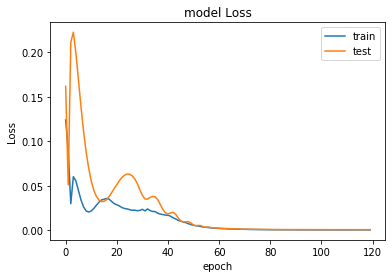

In [510]:
history_sn1 = model_sn1.fit(X_train_sn1, Y_train_sn1, validation_split=validation_split, epochs=120,
                            verbose=1, batch_size=batch_size, shuffle=False)
plt.plot(history_sn1.history['loss'])
plt.plot(history_sn1.history['val_loss'])
plt.title('model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

Saving/loading the model:

In [515]:
model_sn1.save('/home/ahmada59/py/CO2Concentrations_SN1.h5')
# to load the model:
# model_sn1 = load_model('/home/ahmada59/py/CO2Concentrations_SN1.h5')

Forecasting:

In [517]:
trainprediction_sn1 = model_sn1.predict(X_train_sn1)
testprediction_sn1 = model_sn1.predict(X_test_sn1)
trainprediction_sn1 = pd.DataFrame(index=df.index[lag_sn1:len(df)-len(X_test_sn1)], data=trainprediction_sn1)
testprediction_sn1 = pd.DataFrame(index=df.index[len(df)-len(X_test_sn1):], data=testprediction_sn1)

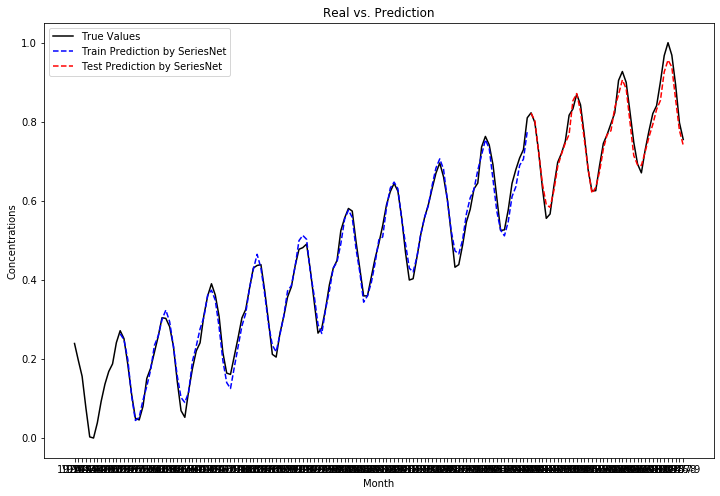

In [518]:
plt.figure(figsize=(12,8))
plt.plot(df.index, df.Concentrations, 'k')
plt.plot(trainprediction_sn1, '--b')
plt.plot(testprediction_sn1, '--r')
plt.title('Real vs. Prediction')
plt.ylabel('Concentrations')
plt.xlabel('Month')
plt.legend(['True Values', 'Train Prediction by SeriesNet', 'Test Prediction by SeriesNet'], loc='best')
plt.show()

In [519]:
Metrics['RMSE_SN1'] = RMSE(Y_test_sn1, testprediction_sn1)
Metrics['MAPE_SN1'] = MAPE(Y_test_sn1, testprediction_sn1)
Metrics['SMAPE_SN1'] = SMAPE(Y_test_sn1, testprediction_sn1)
Metrics['MSLE_SN1'] = MSLE(Y_test_sn1, testprediction_sn1)
Metrics

{'RMSE_SARIMA': 0.01423000301804426,
 'MAPE_SARIMA': 1.5865366875918112,
 'SMAPE_SARIMA': 1.5850406810996358,
 'MSLE_SARIMA': 6.433348881884668e-05,
 'RMSE_MLP': 0.023860435472015638,
 'MAPE_MLP': 15.789529849804262,
 'SMAPE_MLP': 624.6064294055852,
 'MSLE_MLP': 0.00018648175463270236,
 'RMSE_LSTM': 0.02233499336958177,
 'MAPE_LSTM': 16.443648692578037,
 'SMAPE_LSTM': 674.44300437793,
 'MSLE_LSTM': 0.00016366758312043311,
 'RMSE_SUL': 0.03341717551538441,
 'MAPE_SUL': 15.287985251891131,
 'SMAPE_SUL': 600.298397765347,
 'MSLE_SUL': 0.0003837868261487911,
 'RMSE_BL': 0.018727167063783023,
 'MAPE_BL': 15.61053999851306,
 'SMAPE_BL': 628.0273774037925,
 'MSLE_BL': 0.00011168522837371326,
 'RMSE_SBL': 0.05030619285406642,
 'MAPE_SBL': 14.203796650434985,
 'SMAPE_SBL': 597.835927799143,
 'MSLE_SBL': 0.0007449517807820243,
 'RMSE_CNN-LSTM': 0.024295749773294555,
 'MAPE_CNN-LSTM': 16.084739742170402,
 'SMAPE_CNN-LSTM': 637.280778499916,
 'MSLE_CNN-LSTM': 0.0001987554749603132,
 'RMSE_RNN': 0.

# WaveNet:

Source: WAVENET: A GENERATIVEMODEL FOR RAW AUDIO

Code is inspired from https://github.com/peustr/wavenet/blob/master/wavenet


In [93]:
def WaveNetResBlock(input, n_filters, kernel_width, dilation_rate):
    # This function builds one residual block of WaveNet model.
    output_sigmoid = Conv1D(n_filters, kernel_width, dilation_rate=dilation_rate, 
                              padding="causal", activation="sigmoid")(input)
    output_tanh = Conv1D(n_filters, kernel_width, dilation_rate=dilation_rate, 
                           padding="causal", activation="tanh")(input)
    output_mul = Multiply()([output_sigmoid, output_tanh])
    skip_connection = Conv1D(1, 1)(output_mul)
    residual = Add()([input, skip_connection])
    return residual, skip_connection

def Model_Build_WN(length, n_filters, kernel_width, num_residual_blocks):
    # This code builds the WaveNet model.
    # length: length is the number of time steps in the training set of data. If you use 12 lags
    # to train the model, input_size is 12. We assume that it is a univariate time series modeling. 
    # hence, shape of input is [number of samples, number of timesteps, 1] for one feature.
    # n_filters: Number of filters to use in the conv1D layer.
    # kernel_width: The width of the filters to use in convolutiona layers.
    # num_residual_blocks: How many residual blocks to generate between input and output. 
    # Residual block i will have a dilation rate of 2^(i+1), i starting from zero.
    # padding has been changed to causal as we are looking for causal dilated convolutions in order
    # to find get the effect of previous time steps only.
    # dilation rates will start from 1. 
    # as the output we are looking for the future time step in the sequence. So we will have one output.
    
    input = Input(batch_shape=(None,length, 1))
    layer_residual = Conv1D(n_filters, kernel_width, padding="causal")(input)
    skip_connections = []
    for i in range(num_residual_blocks):
        layer_residual, layer_skip_connection = WaveNetResBlock(layer_residual, n_filters, kernel_width, 2**(i+1))
        skip_connections.append(layer_skip_connection)
    s1 = Add()(skip_connections)
    s2 = Activation("relu")(s1)
    s3 = Conv1D(1, 1, activation="relu")(s2)
    s4 = Conv1D(1, 1)(s3)
    s5 = Flatten()(s4)
    s6 = Dense(256, activation="relu")(s5)
    output = Dense(1, activation="relu")(s6)
    model = Model(inputs=[input], outputs=[output])
    adam = optimizers.Adam(lr=0.0005)
    model.compile(loss='mean_squared_error', optimizer=adam, metrics=['accuracy', 'mse'])
    return model

In [94]:
lag_wn = 12
X_train_wn, Y_train_wn, X_test_wn, Y_test_wn = input_output_generator_LSTM(df['Concentrations'].tolist(),
                                                                           lag_wn)
n_filters = 32
kernel_width = 2
num_residual_blocks = 6
batch_size = 10
model_wn = Model_Build_WN(X_train_wn.shape[1],n_filters, kernel_width, num_residual_blocks)
model_wn.summary()

Model: "model_31"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_32 (InputLayer)           (None, 12, 1)        0                                            
__________________________________________________________________________________________________
conv1d_665 (Conv1D)             (None, 12, 32)       96          input_32[0][0]                   
__________________________________________________________________________________________________
conv1d_666 (Conv1D)             (None, 12, 32)       2080        conv1d_665[0][0]                 
__________________________________________________________________________________________________
conv1d_667 (Conv1D)             (None, 12, 32)       2080        conv1d_665[0][0]                 
___________________________________________________________________________________________

Train on 81 samples, validate on 27 samples
Epoch 1/150
81/81 [==============================] - 4s 52ms/step - loss: 0.1399 - accuracy: 0.0000e+00 - mse: 0.1399 - val_loss: 0.3994 - val_accuracy: 0.0000e+00 - val_mse: 0.3994
Epoch 2/150
81/81 [==============================] - 0s 2ms/step - loss: 0.1399 - accuracy: 0.0000e+00 - mse: 0.1399 - val_loss: 0.3994 - val_accuracy: 0.0000e+00 - val_mse: 0.3994
Epoch 3/150
81/81 [==============================] - 0s 2ms/step - loss: 0.1399 - accuracy: 0.0000e+00 - mse: 0.1399 - val_loss: 0.3994 - val_accuracy: 0.0000e+00 - val_mse: 0.3994
Epoch 4/150
81/81 [==============================] - 0s 2ms/step - loss: 0.1399 - accuracy: 0.0000e+00 - mse: 0.1399 - val_loss: 0.3994 - val_accuracy: 0.0000e+00 - val_mse: 0.3994
Epoch 5/150
81/81 [==============================] - 0s 2ms/step - loss: 0.1399 - accuracy: 0.0000e+00 - mse: 0.1399 - val_loss: 0.3994 - val_accuracy: 0.0000e+00 - val_mse: 0.3994
Epoch 6/150
81/81 [==============================]

Epoch 46/150
81/81 [==============================] - 0s 1ms/step - loss: 0.1399 - accuracy: 0.0000e+00 - mse: 0.1399 - val_loss: 0.3994 - val_accuracy: 0.0000e+00 - val_mse: 0.3994
Epoch 47/150
81/81 [==============================] - 0s 1ms/step - loss: 0.1399 - accuracy: 0.0000e+00 - mse: 0.1399 - val_loss: 0.3994 - val_accuracy: 0.0000e+00 - val_mse: 0.3994
Epoch 48/150
81/81 [==============================] - 0s 1ms/step - loss: 0.1399 - accuracy: 0.0000e+00 - mse: 0.1399 - val_loss: 0.3994 - val_accuracy: 0.0000e+00 - val_mse: 0.3994
Epoch 49/150
81/81 [==============================] - 0s 1ms/step - loss: 0.1399 - accuracy: 0.0000e+00 - mse: 0.1399 - val_loss: 0.3994 - val_accuracy: 0.0000e+00 - val_mse: 0.3994
Epoch 50/150
81/81 [==============================] - 0s 1ms/step - loss: 0.1399 - accuracy: 0.0000e+00 - mse: 0.1399 - val_loss: 0.3994 - val_accuracy: 0.0000e+00 - val_mse: 0.3994
Epoch 51/150
81/81 [==============================] - 0s 1ms/step - loss: 0.1399 - accurac

81/81 [==============================] - 0s 1ms/step - loss: 0.1399 - accuracy: 0.0000e+00 - mse: 0.1399 - val_loss: 0.3994 - val_accuracy: 0.0000e+00 - val_mse: 0.3994
Epoch 92/150
81/81 [==============================] - 0s 1ms/step - loss: 0.1399 - accuracy: 0.0000e+00 - mse: 0.1399 - val_loss: 0.3994 - val_accuracy: 0.0000e+00 - val_mse: 0.3994
Epoch 93/150
81/81 [==============================] - 0s 1ms/step - loss: 0.1399 - accuracy: 0.0000e+00 - mse: 0.1399 - val_loss: 0.3994 - val_accuracy: 0.0000e+00 - val_mse: 0.3994
Epoch 94/150
81/81 [==============================] - 0s 1ms/step - loss: 0.1399 - accuracy: 0.0000e+00 - mse: 0.1399 - val_loss: 0.3994 - val_accuracy: 0.0000e+00 - val_mse: 0.3994
Epoch 95/150
81/81 [==============================] - 0s 1ms/step - loss: 0.1399 - accuracy: 0.0000e+00 - mse: 0.1399 - val_loss: 0.3994 - val_accuracy: 0.0000e+00 - val_mse: 0.3994
Epoch 96/150
81/81 [==============================] - 0s 1ms/step - loss: 0.1399 - accuracy: 0.0000e+00

Epoch 136/150
81/81 [==============================] - 0s 1ms/step - loss: 0.1399 - accuracy: 0.0000e+00 - mse: 0.1399 - val_loss: 0.3994 - val_accuracy: 0.0000e+00 - val_mse: 0.3994
Epoch 137/150
81/81 [==============================] - 0s 1ms/step - loss: 0.1399 - accuracy: 0.0000e+00 - mse: 0.1399 - val_loss: 0.3994 - val_accuracy: 0.0000e+00 - val_mse: 0.3994
Epoch 138/150
81/81 [==============================] - 0s 1ms/step - loss: 0.1399 - accuracy: 0.0000e+00 - mse: 0.1399 - val_loss: 0.3994 - val_accuracy: 0.0000e+00 - val_mse: 0.3994
Epoch 139/150
81/81 [==============================] - 0s 1ms/step - loss: 0.1399 - accuracy: 0.0000e+00 - mse: 0.1399 - val_loss: 0.3994 - val_accuracy: 0.0000e+00 - val_mse: 0.3994
Epoch 140/150
81/81 [==============================] - 0s 1ms/step - loss: 0.1399 - accuracy: 0.0000e+00 - mse: 0.1399 - val_loss: 0.3994 - val_accuracy: 0.0000e+00 - val_mse: 0.3994
Epoch 141/150
81/81 [==============================] - 0s 1ms/step - loss: 0.1399 - a

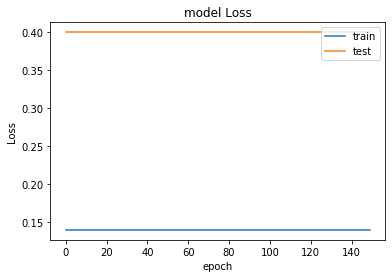

In [95]:
history_wn = model_wn.fit(X_train_wn, Y_train_wn, validation_split=validation_split, epochs=150,
                          verbose=1, batch_size=batch_size, shuffle=False)
plt.plot(history_wn.history['loss'])
plt.plot(history_wn.history['val_loss'])
plt.title('model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

Saving/Loading the model:

In [16]:
model_wn.save('/home/ahmada59/py/CO2Concentrations_WN.h5')
# to load the model:
#model_wn = load_model('/home/ahmada59/py/CO2Concentrations_WN.h5')

Forecasting:

In [17]:
trainprediction_wn = model_wn.predict(X_train_wn)
testprediction_wn = model_wn.predict(X_test_wn)
trainprediction_wn = pd.DataFrame(index=df.index[lag_wn:len(df)-len(X_test_wn)], data=trainprediction_wn)
testprediction_wn = pd.DataFrame(index=df.index[len(df)-len(X_test_wn):], data=testprediction_wn)

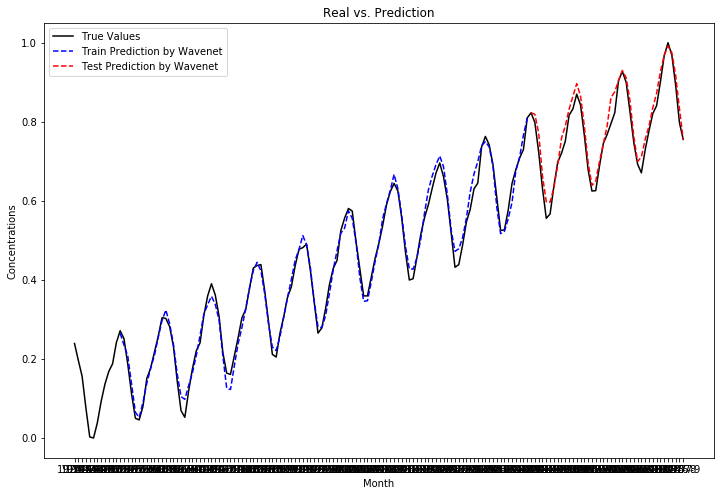

In [18]:
plt.figure(figsize=(12,8))
plt.plot(df.index, df.Concentrations, 'k')
plt.plot(trainprediction_wn, '--b')
plt.plot(testprediction_wn, '--r')
plt.title('Real vs. Prediction')
plt.ylabel('Concentrations')
plt.xlabel('Month')
plt.legend(['True Values', 'Train Prediction by Wavenet', 'Test Prediction by Wavenet'], loc='best')
plt.show()

In [19]:
Metrics['RMSE_WN'] = RMSE(Y_test_wn, testprediction_wn)
Metrics['MAPE_WN'] = MAPE(Y_test_wn, testprediction_wn)
Metrics['SMAPE_WN'] = SMAPE(Y_test_wn, testprediction_wn)
Metrics['MSLE_WN'] = MSLE(Y_test_wn, testprediction_wn)
Metrics

{'RMSE_SARIMA': 0.01423000301804426,
 'MAPE_SARIMA': 1.5865366875918112,
 'SMAPE_SARIMA': 1.5850406810996358,
 'MSLE_SARIMA': 6.433348881884668e-05,
 'RMSE_MLP': 0.023860435472015638,
 'MAPE_MLP': 15.789529849804262,
 'SMAPE_MLP': 624.6064294055852,
 'MSLE_MLP': 0.00018648175463270236,
 'RMSE_LSTM': 0.02233499336958177,
 'MAPE_LSTM': 16.443648692578037,
 'SMAPE_LSTM': 674.44300437793,
 'MSLE_LSTM': 0.00016366758312043311,
 'RMSE_SUL': 0.03341717551538441,
 'MAPE_SUL': 15.287985251891131,
 'SMAPE_SUL': 600.298397765347,
 'MSLE_SUL': 0.0003837868261487911,
 'RMSE_BL': 0.018727167063783023,
 'MAPE_BL': 15.61053999851306,
 'SMAPE_BL': 628.0273774037925,
 'MSLE_BL': 0.00011168522837371326,
 'RMSE_SBL': 0.05030619285406642,
 'MAPE_SBL': 14.203796650434985,
 'SMAPE_SBL': 597.835927799143,
 'MSLE_SBL': 0.0007449517807820243,
 'RMSE_CNN-LSTM': 0.024295749773294555,
 'MAPE_CNN-LSTM': 16.084739742170402,
 'SMAPE_CNN-LSTM': 637.280778499916,
 'MSLE_CNN-LSTM': 0.0001987554749603132,
 'RMSE_RNN': 0.

In [7]:
Metrics = {'RMSE_ARIMA': 0.01423000301804426,
 'MAPE_ARIMA': 1.5865366875918112,
 'SMAPE_ARIMA': 1.5850406810996358,
 'MSLE_ARIMA': 6.433348881884668e-05,
 'RMSE_MLP': 0.023860435472015638,
 'MAPE_MLP': 15.789529849804262,
 'SMAPE_MLP': 624.6064294055852,
 'MSLE_MLP': 0.00018648175463270236,
 'RMSE_LSTM': 0.02233499336958177,
 'MAPE_LSTM': 16.443648692578037,
 'SMAPE_LSTM': 674.44300437793,
 'MSLE_LSTM': 0.00016366758312043311,
 'RMSE_SUL': 0.03341717551538441,
 'MAPE_SUL': 15.287985251891131,
 'SMAPE_SUL': 600.298397765347,
 'MSLE_SUL': 0.0003837868261487911,
 'RMSE_BL': 0.018727167063783023,
 'MAPE_BL': 15.61053999851306,
 'SMAPE_BL': 628.0273774037925,
 'MSLE_BL': 0.00011168522837371326,
 'RMSE_SBL': 0.05030619285406642,
 'MAPE_SBL': 14.203796650434985,
 'SMAPE_SBL': 597.835927799143,
 'MSLE_SBL': 0.0007449517807820243,
 'RMSE_CNN-LSTM': 0.024295749773294555,
 'MAPE_CNN-LSTM': 16.084739742170402,
 'SMAPE_CNN-LSTM': 637.280778499916,
 'MSLE_CNN-LSTM': 0.0001987554749603132,
 'RMSE_RNN': 0.02021239772746064,
 'MAPE_RNN': 15.161703705299384,
 'SMAPE_RNN': 610.836388290537,
 'MSLE_RNN': 0.00012660439527503736,
 'RMSE_GRU': 0.049774461456206745,
 'MAPE_GRU': 16.092275764545295,
 'SMAPE_GRU': 651.493455075346,
 'MSLE_GRU': 0.0007771783360136213,
 'RMSE_DCCNN': 0.02123023253684602,
 'MAPE_DCCNN': 15.797755047503989,
 'SMAPE_DCCNN': 630.8818489476008,
 'MSLE_DCCNN': 0.00014255579840923176,
 'RMSE_SN1': 0.022050093863163447,
 'MAPE_SN1': 15.25659267287158,
 'SMAPE_SN1': 621.1845198702264,
 'MSLE_SN1': 0.00014670701237475792,
 'RMSE_WN': 0.02652952597464603,
 'MAPE_WN': 16.387305060143454,
 'SMAPE_WN': 642.5118603154715,
 'MSLE_WN': 0.00022550694353884213}

Saving the Metrics in a pickle file:

In [8]:
with open('/home/ahmada59/py/NN_CO2Concentrations.pkl', 'wb') as f:
    pickle.dump(Metrics, f)
#with open('/home/ahmada59/py/NN_CO2Concentrations.pkl', 'rb') as f:
#    pickle.load(f)